<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=200 height=200 align=left class="saturate"> -->

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Computer Simulation <br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Smart Grid Simulation <br>
<font color=3CA80 size=4>
Matin Mirzababaie 400102114 <br>
<font color=3CA80 size=4>
Ali Ekhterachian 400100576


----

In [1]:
from __future__ import annotations

from dataclasses import dataclass, field
from typing import Dict, Optional, List, Tuple, Literal
from enum import Enum, auto
from collections import deque
import heapq
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


# silence future pandas groupby warning in our summaries (optional)
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.core.groupby")

# reproducibility
DEFAULT_SEED = 42
rng = np.random.default_rng(DEFAULT_SEED)

Time = float
ID = int


In [2]:
class PolicyType(Enum):
    FIFO = auto()
    NPPS = auto()   # Non-Preemptive Priority Scheduling
    WRR  = auto()   # Weighted Round Robin
    EDF  = auto()   # Earliest Deadline First

@dataclass
class SimConfig:
    # --- non-defaults first ---
    chi_arrival: float                   # χ — Poisson arrival rate
    lambda_ctrl: float                   # λ1 — controller service rate (exp)
    lambda_res: Dict[str, float]         # λ2 per resource {'PV':6, 'BAT':12, ...}
    setup_delay: float                   # t — fixed setup delay (ctrl & res)
    T: Time                              # total horizon
    N_ctrl: int                          # number of controller servers (M/M/N)
    transfer_overhead: Dict[str, float]  # C_time per resource (routing delay)
    route_probs: Dict[str, float]        # P routing probabilities to resources

    # --- defaults below ---
    ctrl_policy: PolicyType = PolicyType.FIFO

    # priorities & default deadlines (slots interpreted in same time unit)
    group_priority: Dict[str, int] = field(
        default_factory=lambda: {"essential": 3, "delay_sensitive": 2, "delay_tolerant": 1}
    )
    default_deadline_slots: Dict[str, Tuple[int,int]] = field(
        default_factory=lambda: {"delay_sensitive": (1,4), "delay_tolerant": (3,12)}
    )
    seed: int = DEFAULT_SEED

    def validate(self):
        assert self.chi_arrival > 0, "chi_arrival must be > 0"
        assert self.lambda_ctrl > 0, "lambda_ctrl must be > 0"
        assert all(v > 0 for v in self.lambda_res.values()), "All lambda_res must be > 0"
        assert self.N_ctrl >= 1, "N_ctrl must be >= 1"
        assert self.T > 0, "T must be > 0"
        s = sum(self.route_probs.values())
        assert abs(s - 1.0) < 1e-8, f"route_probs must sum to 1 (got {s})"
        # keys must align
        for r in self.transfer_overhead:
            assert r in self.lambda_res, f"transfer_overhead key {r} missing in lambda_res"
        for r in self.lambda_res:
            assert r in self.transfer_overhead, f"lambda_res key {r} missing in transfer_overhead"


In [3]:
from math import inf

@dataclass
class Request:
    rid: ID
    group: str                          # 'essential' | 'delay_sensitive' | 'delay_tolerant' | ...
    priority: int                       # for NPPS
    arrival_time: Time
    deadline_time: Optional[Time] = None

    # timestamps through system
    t_ctrl_start: Optional[Time] = None
    t_ctrl_end:   Optional[Time] = None
    routed_to:    Optional[str]  = None
    t_route_done: Optional[Time] = None
    t_res_start:  Optional[Time] = None
    t_res_end:    Optional[Time] = None

class BaseQueuePolicy:
    def push(self, req: Request) -> None: ...
    def pop(self, now: Time) -> Optional[Request]: ...
    def __len__(self) -> int: ...

class FIFOQueue(BaseQueuePolicy):
    def __init__(self): self._q = deque()
    def push(self, req: Request) -> None: self._q.append(req)
    def pop(self, now: Time) -> Optional[Request]:
        return self._q.popleft() if self._q else None
    def __len__(self) -> int: return len(self._q)

class NPPSQueue(BaseQueuePolicy):
    """Higher priority first; FIFO within same priority."""
    def __init__(self):
        self._counter = 0
        self._heap: List[Tuple[int, int, Request]] = []  # (-priority, order, req)
    def push(self, req: Request) -> None:
        self._counter += 1
        heapq.heappush(self._heap, (-int(req.priority), self._counter, req))
    def pop(self, now: Time) -> Optional[Request]:
        if not self._heap: return None
        _, _, req = heapq.heappop(self._heap)
        return req
    def __len__(self) -> int: return len(self._heap)

class EDFQueue(BaseQueuePolicy):
    """Earliest absolute deadline first; FIFO on ties; NaN/None treated as +inf."""
    def __init__(self):
        self._counter = 0
        self._heap: List[Tuple[float, int, Request]] = []  # (deadline, order, req)
    def push(self, req: Request) -> None:
        self._counter += 1
        dl = req.deadline_time if (req.deadline_time is not None) else inf
        heapq.heappush(self._heap, (float(dl), self._counter, req))
    def pop(self, now: Time) -> Optional[Request]:
        if not self._heap: return None
        _, _, req = heapq.heappop(self._heap)
        return req
    def __len__(self) -> int: return len(self._heap)

class WRRQueue(BaseQueuePolicy):
    """
    Weighted Round Robin over groups (each group has FIFO).
    Weights are positive numbers; internally normalized to small integers.
    """
    def __init__(self, group_weights: Dict[str, float]):
        assert all(w > 0 for w in group_weights.values()), "WRR weights must be > 0"
        self.fifos: Dict[str, deque] = {g: deque() for g in group_weights}
        # normalize to small integers for quotas
        g, w = zip(*group_weights.items())
        base = min(w)
        ints = {gi: max(1, int(round(wi / base))) for gi, wi in group_weights.items()}
        self.weights = ints
        self.groups = list(self.fifos.keys())
        self.idx = 0
        self.quota_left = dict(self.weights)

    def push(self, req: Request) -> None:
        if req.group not in self.fifos:
            # unseen group gets weight 1 lazily
            self.fifos[req.group] = deque()
            self.weights[req.group] = 1
            self.groups.append(req.group)
            self.quota_left[req.group] = 1
        self.fifos[req.group].append(req)

    def _advance(self): self.idx = (self.idx + 1) % len(self.groups)
    def _has_any(self) -> bool: return any(self.fifos[g] for g in self.groups)

    def pop(self, now: Time) -> Optional[Request]:
        if not self._has_any(): return None
        tried = 0
        while tried < len(self.groups):
            g = self.groups[self.idx]
            # reset cycle quotas if all exhausted
            if all(self.quota_left[x] == 0 for x in self.groups):
                self.quota_left = dict(self.weights)
            if self.quota_left[g] == 0 or not self.fifos[g]:
                self._advance(); tried += 1; continue
            self.quota_left[g] -= 1
            return self.fifos[g].popleft()
        # queues changed; reset quotas and retry once
        self.quota_left = dict(self.weights)
        return self.pop(now)


In [4]:
def make_queue(policy: PolicyType, *, wrr_weights: Optional[Dict[str, float]] = None) -> BaseQueuePolicy:
    if policy == PolicyType.FIFO: return FIFOQueue()
    if policy == PolicyType.NPPS: return NPPSQueue()
    if policy == PolicyType.EDF:  return EDFQueue()
    if policy == PolicyType.WRR:
        assert wrr_weights is not None and len(wrr_weights) > 0, "Provide wrr_weights for WRR"
        return WRRQueue(wrr_weights)
    raise NotImplementedError(policy)


In [5]:
class EventType(Enum):
    ARRIVAL = auto()       # to controller
    CTRL_FINISH = auto()   # controller finished a request
    RES_ARRIVAL = auto()   # arrival to a resource after transfer overhead
    RES_FINISH = auto()    # resource finished

@dataclass(order=True)
class Event:
    time: Time
    etype: EventType
    payload: dict = field(compare=False)

class ResourceServer:
    """Single-server M/M/1 resource with FIFO queue (per resource)."""
    def __init__(self, name: str, rate: float, setup_delay: float):
        self.name = name
        self.rate = rate
        self.setup_delay = setup_delay
        self.queue = deque()
        self.busy_until: Time = 0.0
        self.in_service: Optional[Request] = None

    def push(self, req: Request):
        self.queue.append(req)

    def try_start(self, now: Time, evq: List[Event]):
        if self.in_service is not None: return False
        if self.queue and self.busy_until <= now:
            req = self.queue.popleft()
            req.t_res_start = now
            svc = rng.exponential(1.0 / self.rate) + self.setup_delay
            finish = now + svc
            self.busy_until = finish
            self.in_service = req
            heapq.heappush(evq, Event(finish, EventType.RES_FINISH, {"res": self.name, "req": req}))
            return True
        return False

    def on_finish(self, now: Time):
        req = self.in_service
        if req: req.t_res_end = now
        self.in_service = None
        self.busy_until = now

class ResourcePool:
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        self.resources: Dict[str, ResourceServer] = {
            rname: ResourceServer(rname, rate=lambda_rate, setup_delay=cfg.setup_delay)
            for rname, lambda_rate in cfg.lambda_res.items()
        }

    def route_choice(self) -> str:
        names = list(self.cfg.route_probs.keys())
        probs = np.array(list(self.cfg.route_probs.values()))
        return rng.choice(names, p=probs)

    def on_ctrl_finish(self, req: Request, now: Time, evq: List[Event]):
        rname = self.route_choice()
        req.routed_to = rname
        req.t_ctrl_end = now
        overhead = self.cfg.transfer_overhead.get(rname, 0.0)
        arrival_at_res = now + overhead
        req.t_route_done = arrival_at_res
        heapq.heappush(evq, Event(arrival_at_res, EventType.RES_ARRIVAL, {"res": rname, "req": req}))

    def on_res_arrival(self, rname: str, req: Request, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.push(req)
        res.try_start(now, evq)

    def on_res_finish(self, rname: str, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.on_finish(now)
        res.try_start(now, evq)

class MultiServerController:
    """Controller M/M/N with pluggable queue."""
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        if cfg.ctrl_policy == PolicyType.WRR:
            # by default map weights from priorities (custom dict welcome too)
            wrr_weights = {g: float(p) for g, p in cfg.group_priority.items()}
            self.queue = make_queue(cfg.ctrl_policy, wrr_weights=wrr_weights)
        else:
            self.queue = make_queue(cfg.ctrl_policy)
        self.server_busy_until: List[Time] = [0.0] * cfg.N_ctrl
        self.in_service: Dict[int, Request] = {}

    def _first_free_server(self, now: Time) -> Optional[int]:
        for sid, busy_until in enumerate(self.server_busy_until):
            if busy_until <= now and self.in_service.get(sid) is None:
                return sid
        return None

    def try_start_service(self, now: Time, evq: List[Event]):
        started = 0
        while True:
            sid = self._first_free_server(now)
            if sid is None: break
            req = self.queue.pop(now)
            if req is None: break
            req.t_ctrl_start = now
            svc = rng.exponential(1.0 / self.cfg.lambda_ctrl) + self.cfg.setup_delay
            finish = now + svc
            self.server_busy_until[sid] = finish
            self.in_service[sid] = req
            heapq.heappush(evq, Event(finish, EventType.CTRL_FINISH, {"sid": sid, "req": req}))
            started += 1
        return started

    def on_arrival(self, req: Request, now: Time, evq: List[Event]):
        self.queue.push(req)
        self.try_start_service(now, evq)

    def on_finish(self, sid: int, now: Time) -> Request:
        self.server_busy_until[sid] = now
        return self.in_service.pop(sid)


In [6]:
def generate_next_arrival(prev_time: Time, chi: float) -> Time:
    return prev_time + rng.exponential(1.0 / chi)

def _sample_deadline_for_group(cfg: SimConfig, group: str, arrival_time: float) -> Optional[float]:
    if group in cfg.default_deadline_slots:
        lo, hi = cfg.default_deadline_slots[group]
        delta = float(rng.uniform(lo, hi))
        return arrival_time + delta
    return None

def bootstrap_requests(cfg: SimConfig, group_mix: Dict[str, float]) -> List[Request]:
    assert abs(sum(group_mix.values()) - 1.0) < 1e-8, "group_mix must sum to 1"
    t = 0.0
    rid = 0
    reqs: List[Request] = []
    groups = list(group_mix.keys())
    probs  = np.array(list(group_mix.values()))
    while t < cfg.T:
        t = generate_next_arrival(t, cfg.chi_arrival)
        if t >= cfg.T: break
        g = rng.choice(groups, p=probs)
        pr = cfg.group_priority.get(g, 1)
        dl = _sample_deadline_for_group(cfg, g, t)
        reqs.append(Request(
            rid=rid, group=g, priority=pr,
            arrival_time=t, deadline_time=dl
        ))
        rid += 1
    return reqs


In [7]:
def generate_next_arrival(prev_time: Time, chi: float) -> Time:
    return prev_time + rng.exponential(1.0 / chi)

def _sample_deadline_for_group(cfg: SimConfig, group: str, arrival_time: float) -> Optional[float]:
    if group in cfg.default_deadline_slots:
        lo, hi = cfg.default_deadline_slots[group]
        delta = float(rng.uniform(lo, hi))
        return arrival_time + delta
    return None

def bootstrap_requests(cfg: SimConfig, group_mix: Dict[str, float]) -> List[Request]:
    assert abs(sum(group_mix.values()) - 1.0) < 1e-8, "group_mix must sum to 1"
    t = 0.0
    rid = 0
    reqs: List[Request] = []
    groups = list(group_mix.keys())
    probs  = np.array(list(group_mix.values()))
    while t < cfg.T:
        t = generate_next_arrival(t, cfg.chi_arrival)
        if t >= cfg.T: break
        g = rng.choice(groups, p=probs)
        pr = cfg.group_priority.get(g, 1)
        dl = _sample_deadline_for_group(cfg, g, t)
        reqs.append(Request(
            rid=rid, group=g, priority=pr,
            arrival_time=t, deadline_time=dl
        ))
        rid += 1
    return reqs


In [8]:
def summarize_metrics(df: pd.DataFrame):
    """
    Returns (overall_df, per_group_df, miss_df or None)
    overall/per_group: count/valid, mean, median, p95 for core timing columns.
    miss_df: per-group deadline meeting/miss stats (+ __OVERALL__), if 'deadline' present.
    """
    if df.empty:
        return pd.DataFrame(), pd.DataFrame(), None

    cols = ["wait_ctrl", "svc_ctrl", "transfer", "wait_res", "svc_res", "total_response"]

    overall = df[cols].agg(["count", "mean", "median", lambda s: s.quantile(0.95)]).T
    overall.columns = ["count/valid", "mean", "median", "p95"]
    overall = overall.sort_index()

    # exclude grouping col from apply to avoid future behavior change
    per_group = df.groupby("group", dropna=False)[cols].apply(
        lambda g: g.agg(["count", "mean", "median", lambda s: s.quantile(0.95)]).T
    )
    per_group.columns = ["count/valid", "mean", "median", "p95"]

    # deadline miss table
    miss_table = None
    if "deadline" in df.columns:
        m = df.dropna(subset=["deadline"]).copy()
        if not m.empty:
            m["deadline_met"] = (m["res_end"] <= m["deadline"]).astype(int)
            g = m.groupby("group", dropna=False)["deadline_met"].agg(count="count", met="sum")
            g["misses"] = g["count"] - g["met"]
            g["miss_rate"] = g["misses"] / g["count"]
            overall_miss = pd.DataFrame({
                "count": [g["count"].sum()],
                "met": [g["met"].sum()],
                "misses": [g["misses"].sum()],
                "miss_rate": [g["misses"].sum() / max(1, g["count"].sum())]
            }, index=["__OVERALL__"])
            miss_table = pd.concat([g, overall_miss])

    return overall, per_group, miss_table


In [9]:
def run_simulation(cfg: SimConfig, group_mix: Dict[str, float]) -> pd.DataFrame:
    cfg.validate()
    # reset RNG per run
    global rng
    rng = np.random.default_rng(cfg.seed)

    reqs = bootstrap_requests(cfg, group_mix)
    controller = MultiServerController(cfg)
    pool = ResourcePool(cfg)

    # prime event queue with arrivals
    evq: List[Event] = []
    for req in reqs:
        heapq.heappush(evq, Event(req.arrival_time, EventType.ARRIVAL, {"req": req}))

    # main loop
    while evq:
        ev = heapq.heappop(evq)
        now = ev.time
        if now > cfg.T: break

        if ev.etype == EventType.ARRIVAL:
            controller.on_arrival(ev.payload["req"], now, evq)

        elif ev.etype == EventType.CTRL_FINISH:
            sid = ev.payload["sid"]
            req: Request = controller.on_finish(sid, now)
            pool.on_ctrl_finish(req, now, evq)
            controller.try_start_service(now, evq)

        elif ev.etype == EventType.RES_ARRIVAL:
            rname = ev.payload["res"]
            req: Request = ev.payload["req"]
            pool.on_res_arrival(rname, req, now, evq)

        elif ev.etype == EventType.RES_FINISH:
            rname = ev.payload["res"]
            pool.on_res_finish(rname, now, evq)

    # assemble results
    finished: List[Request] = [r for r in reqs if r.t_res_end is not None]

    def safe(x): return None if x is None else float(x)

    rows = []
    for r in finished:
        wait_ctrl = (r.t_ctrl_start - r.arrival_time) if (r.t_ctrl_start is not None) else None
        svc_ctrl  = (r.t_ctrl_end - r.t_ctrl_start) if (r.t_ctrl_end is not None and r.t_ctrl_start is not None) else None
        transfer  = (r.t_route_done - r.t_ctrl_end) if (r.t_route_done is not None and r.t_ctrl_end is not None) else None
        wait_res  = (r.t_res_start - r.t_route_done) if (r.t_res_start is not None and r.t_route_done is not None) else None
        svc_res   = (r.t_res_end - r.t_res_start) if (r.t_res_end is not None and r.t_res_start is not None) else None
        total     = (r.t_res_end - r.arrival_time) if (r.t_res_end is not None) else None

        rows.append({
            "rid": r.rid,
            "group": r.group,
            "priority": r.priority,
            "arrival": safe(r.arrival_time),
            "deadline": safe(r.deadline_time),
            "ctrl_start": safe(r.t_ctrl_start),
            "ctrl_end": safe(r.t_ctrl_end),
            "routed_to": r.routed_to,
            "route_done": safe(r.t_route_done),
            "res_start": safe(r.t_res_start),
            "res_end": safe(r.t_res_end),
            "wait_ctrl": safe(wait_ctrl),
            "svc_ctrl": safe(svc_ctrl),
            "transfer": safe(transfer),
            "wait_res": safe(wait_res),
            "svc_res": safe(svc_res),
            "total_response": safe(total),
        })

    return pd.DataFrame(rows)


In [10]:
def run_policy_sweep(cfg_base: SimConfig, group_mix: Dict[str, float],
                     policies: List[PolicyType]) -> pd.DataFrame:
    """
    Runs multiple controller policies on the same base config (cloned per run)
    and returns a compact summary table.
    """
    rows = []
    for pol in policies:
        cfg = SimConfig(
            chi_arrival=cfg_base.chi_arrival,
            lambda_ctrl=cfg_base.lambda_ctrl,
            lambda_res=dict(cfg_base.lambda_res),
            setup_delay=cfg_base.setup_delay,
            T=cfg_base.T,
            N_ctrl=cfg_base.N_ctrl,
            transfer_overhead=dict(cfg_base.transfer_overhead),
            route_probs=dict(cfg_base.route_probs),
            ctrl_policy=pol,
            group_priority=dict(cfg_base.group_priority),
            default_deadline_slots=dict(cfg_base.default_deadline_slots),
            seed=cfg_base.seed
        )
        df = run_simulation(cfg, group_mix)
        overall, per_group, miss = summarize_metrics(df)

        row = {
            "policy": pol.name,
            "count": overall.loc["total_response", "count/valid"],
            "total_mean": overall.loc["total_response", "mean"],
            "total_p95": overall.loc["total_response", "p95"],
            "wait_ctrl_mean": overall.loc["wait_ctrl", "mean"],
            "wait_res_mean": overall.loc["wait_res", "mean"],
            "svc_ctrl_mean": overall.loc["svc_ctrl", "mean"],
            "svc_res_mean": overall.loc["svc_res", "mean"],
            "transfer_mean": overall.loc["transfer", "mean"],
            "deadline_miss_rate": np.nan
        }
        if miss is not None and "__OVERALL__" in miss.index:
            row["deadline_miss_rate"] = float(miss.loc["__OVERALL__", "miss_rate"])

        rows.append(row)

    return pd.DataFrame(rows).sort_values(by=["total_mean", "total_p95"]).reset_index(drop=True)

def with_load(cfg: SimConfig, chi_new: float, seed: Optional[int] = None) -> SimConfig:
    return SimConfig(
        chi_arrival=chi_new,
        lambda_ctrl=cfg.lambda_ctrl,
        lambda_res=dict(cfg.lambda_res),
        setup_delay=cfg.setup_delay,
        T=cfg.T,
        N_ctrl=cfg.N_ctrl,
        transfer_overhead=dict(cfg.transfer_overhead),
        route_probs=dict(cfg.route_probs),
        ctrl_policy=cfg.ctrl_policy,
        group_priority=dict(cfg.group_priority),
        default_deadline_slots=dict(cfg.default_deadline_slots),
        seed=cfg.seed if seed is None else seed
    )


In [11]:
def utilization_report(cfg: SimConfig, df: pd.DataFrame) -> pd.DataFrame:
    """
    Rough utilization ρ estimates over horizon T:
      - Controller: sum(svc_ctrl) / (N_ctrl * T)
      - Resource s: sum(svc_res for routed_to==s) / T
    """
    if df.empty:
        return pd.DataFrame()

    out = []
    ctrl_busy = df["svc_ctrl"].dropna().sum()
    rho_ctrl = (ctrl_busy / cfg.N_ctrl) / cfg.T
    out.append({"unit": "CONTROLLER", "rho": rho_ctrl, "busy_time": ctrl_busy, "servers": cfg.N_ctrl})

    for rname in cfg.lambda_res.keys():
        busy = df.loc[df["routed_to"] == rname, "svc_res"].dropna().sum()
        rho = busy / cfg.T
        out.append({"unit": f"RES::{rname}", "rho": rho, "busy_time": busy, "servers": 1})

    rep = pd.DataFrame(out)
    rep["rho_clipped"] = rep["rho"].clip(upper=1.0)
    rep["warning"] = np.where(rep["rho"] >= 1.0, "UNSTABLE (ρ≥1)", "")
    return rep


def deadline_dashboard(df: pd.DataFrame) -> pd.DataFrame:
    """
    Per-group and overall deadline meeting stats.
    A request 'meets deadline' iff res_end <= deadline. NaN deadlines are ignored.
    """
    if "deadline" not in df.columns or df["deadline"].isna().all():
        return pd.DataFrame({"note": ["no deadlines present"]})

    m = df.dropna(subset=["deadline"]).copy()
    if m.empty:
        return pd.DataFrame({"note": ["no finite deadlines present"]})

    m["met"] = (m["res_end"] <= m["deadline"]).astype(int)
    g = m.groupby("group", dropna=False)["met"].agg(count="count", met="sum")
    g["misses"] = g["count"] - g["met"]
    g["miss_rate"] = g["misses"] / g["count"]

    overall = pd.DataFrame({
        "count": [g["count"].sum()],
        "met": [g["met"].sum()],
        "misses": [g["misses"].sum()],
        "miss_rate": [g["misses"].sum() / max(1, g["count"].sum())]
    }, index=["__OVERALL__"])

    return pd.concat([g, overall])


In [12]:
cfg = SimConfig(
    chi_arrival=8.0,
    # lambda_ctrl=10.0,
    # lambda_ctrl=6.0,
    lambda_ctrl=7.0,
    lambda_res={"PV":6.0, "BAT":12.0, "GRID":20.0},
    # setup_delay=0.02,
    setup_delay=0.05,
    T=240.0,
    N_ctrl=2,
    transfer_overhead={"PV":0.03, "BAT":0.02, "GRID":0.01},
    route_probs={"PV":0.35, "BAT":0.25, "GRID":0.40},
    ctrl_policy=PolicyType.FIFO,
)
# group_mix = {"essential":0.2, "delay_sensitive":0.4, "delay_tolerant":0.4}

# df = run_simulation(cfg, group_mix)
# overall, per_group, miss = summarize_metrics(df)
# rep = utilization_report(cfg, df)
# dash = deadline_dashboard(df)

# display(df.head(), overall, per_group, miss, rep, dash)

# # try NPPS / EDF / WRR
# table = run_policy_sweep(cfg, group_mix, [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])
# display(table)

# # stress
# sweep_light = run_policy_sweep(with_load(cfg, 6.0), group_mix, [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])
# sweep_heavy = run_policy_sweep(with_load(cfg, 12.0), group_mix, [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])
# display(sweep_light, sweep_heavy)


In [13]:
from IPython.display import display, HTML

def styled_table(df, title=None, highlight=None):
    styled = df.style.set_caption(title).set_table_styles(
        [{'selector': 'caption',
          'props': [('color', 'black'), ('font-size', '16px'),
                    ('text-align', 'left'), ('font-weight', 'bold')]}]
    )

    numeric_cols = df.select_dtypes(include=["number"]).columns

    if highlight == "min":
        for col in numeric_cols:
            if df[col].nunique() > 1:  # only highlight if values differ
                styled = styled.highlight_min(subset=[col], color="lightgreen", axis=0)
    elif highlight == "max":
        for col in numeric_cols:
            if df[col].nunique() > 1:
                styled = styled.highlight_max(subset=[col], color="lightblue", axis=0)

    return styled


# --- Run simulations ---
group_mix = {"essential":0.2, "delay_sensitive":0.4, "delay_tolerant":0.4}

df = run_simulation(cfg, group_mix)
overall, per_group, miss = summarize_metrics(df)
rep = utilization_report(cfg, df)
dash = deadline_dashboard(df)

# --- Policy comparison ---
display(HTML("<h2>Policy Sweep</h2>"))
table = run_policy_sweep(cfg, group_mix,
                         [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])
display(styled_table(table, "Policy Comparison", highlight="min"))

# --- Stress tests ---
display(HTML("<h2>Stress Test Comparison</h2>"))
sweep_light = run_policy_sweep(with_load(cfg, 6.0), group_mix,
                               [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])
sweep_heavy = run_policy_sweep(with_load(cfg, 12.0), group_mix,
                               [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF])

display(styled_table(sweep_light, "Light Load (chi=6)", highlight="min"))
display(styled_table(sweep_heavy, "Heavy Load (chi=12)", highlight="min"))


,policy,count,total_mean,total_p95,wait_ctrl_mean,wait_res_mean,svc_ctrl_mean,svc_res_mean,transfer_mean,deadline_miss_rate
0,NPPS,1938.000000,0.667422,1.789528,0.216612,0.095443,0.190625,0.145558,0.019185,0.004505
1,FIFO,1938.000000,0.667422,1.537640,0.216612,0.095443,0.190625,0.145558,0.019185,0.012870
2,EDF,1938.000000,0.667422,1.692594,0.216612,0.095443,0.190625,0.145558,0.019185,0.002574
3,WRR,1938.000000,0.667422,1.706696,0.216612,0.095443,0.190625,0.145558,0.019185,0.011583


,policy,count,total_mean,total_p95,wait_ctrl_mean,wait_res_mean,svc_ctrl_mean,svc_res_mean,transfer_mean,deadline_miss_rate
0,FIFO,1450.000000,0.482512,1.039004,0.073042,0.055943,0.189084,0.145325,0.019117,0.003436
1,NPPS,1450.000000,0.482512,1.072139,0.073042,0.055943,0.189084,0.145325,0.019117,0.003436
2,EDF,1450.000000,0.482512,1.072418,0.073042,0.055943,0.189084,0.145325,0.019117,0.002577
3,WRR,1450.000000,0.482512,1.075811,0.073042,0.055943,0.189084,0.145325,0.019117,0.004296


,policy,count,total_mean,total_p95,wait_ctrl_mean,wait_res_mean,svc_ctrl_mean,svc_res_mean,transfer_mean,deadline_miss_rate
0,EDF,2485.000000,6.601965,8.383242,5.873411,0.363370,0.191853,0.154040,0.019292,0.037307
1,NPPS,2485.000000,13.971645,76.399864,13.243091,0.363370,0.191853,0.154040,0.019292,0.392894
2,WRR,2485.000000,14.208216,76.512315,13.479662,0.363370,0.191853,0.154040,0.019292,0.606900
3,FIFO,2485.000000,18.376172,33.635775,17.647618,0.363370,0.191853,0.154040,0.019292,0.858652


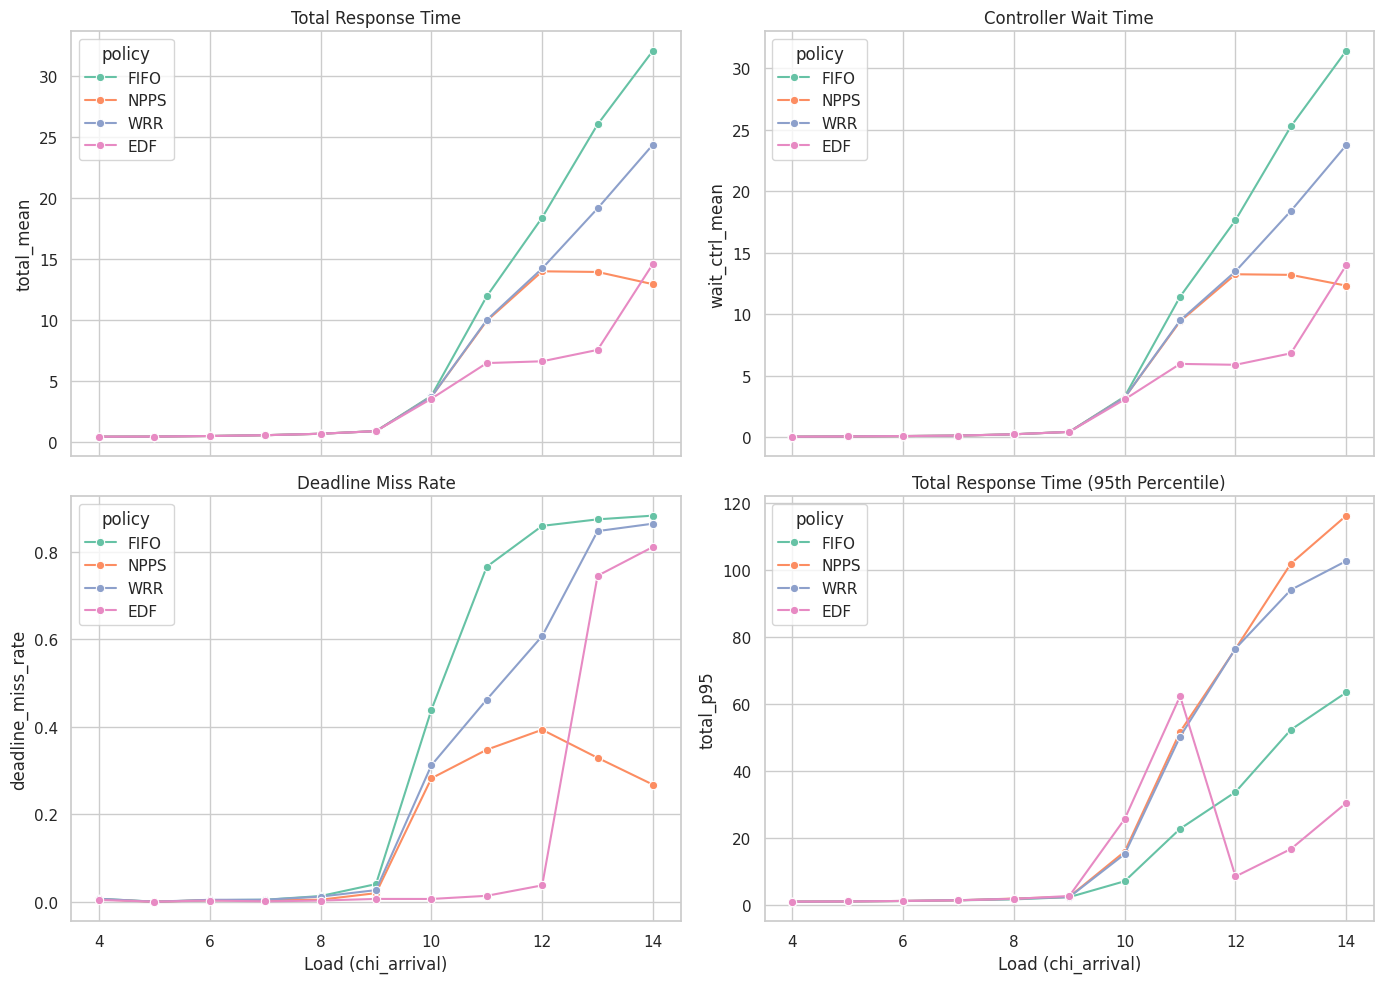

In [14]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14,10)


def compute_utilization_metrics(cfg: SimConfig, df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds controller utilization and max resource utilization per run.
    """
    ctrl_busy = df["svc_ctrl"].dropna().sum()
    rho_ctrl = (ctrl_busy / cfg.N_ctrl) / cfg.T

    res_rho = []
    for rname in cfg.lambda_res.keys():
        busy = df.loc[df["routed_to"] == rname, "svc_res"].dropna().sum()
        rho = busy / cfg.T
        res_rho.append(rho)
    max_res_rho = max(res_rho) if res_rho else 0.0

    return pd.DataFrame({
        "ctrl_utilization": [rho_ctrl],
        "max_res_utilization": [max_res_rho]
    })

def policy_load_sweep_for_plot(cfg: SimConfig, group_mix: dict, policies: list, loads: np.ndarray):
    """
    Collect metrics for line plots using only run_policy_sweep aggregated metrics.
    """
    all_rows = []
    for chi in loads:
        cfg_load = with_load(cfg, chi)
        df_sweep = run_policy_sweep(cfg_load, group_mix, policies)
        df_sweep["chi_arrival"] = chi
        all_rows.append(df_sweep)
    return pd.concat(all_rows, ignore_index=True)

def plot_sweep_metrics_2x2(sweep_df: pd.DataFrame):
    metrics = ["total_mean", "wait_ctrl_mean", "deadline_miss_rate", "total_p95"]
    titles = ["Total Response Time", "Controller Wait Time", "Deadline Miss Rate", "Total Response Time (95th Percentile)"]

    fig, axes = plt.subplots(2, 2, figsize=(14,10), sharex=True)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(
            x="chi_arrival", y=metric, hue="policy",
            data=sweep_df, marker="o", ax=ax, palette="Set2"
        )
        ax.set_title(titles[i])
        ax.grid(True)
        if i >= 2:
            ax.set_xlabel("Load (chi_arrival)")
        else:
            ax.set_xlabel("")
        ax.set_ylabel(metric)

    plt.tight_layout()
    plt.show()


policies = [PolicyType.FIFO, PolicyType.NPPS, PolicyType.WRR, PolicyType.EDF]
loads = np.linspace(4.0, 14.0, 11)

sweep_df = policy_load_sweep_for_plot(cfg, group_mix, policies, np.linspace(4.0, 14.0, 11))
plot_sweep_metrics_2x2(sweep_df)

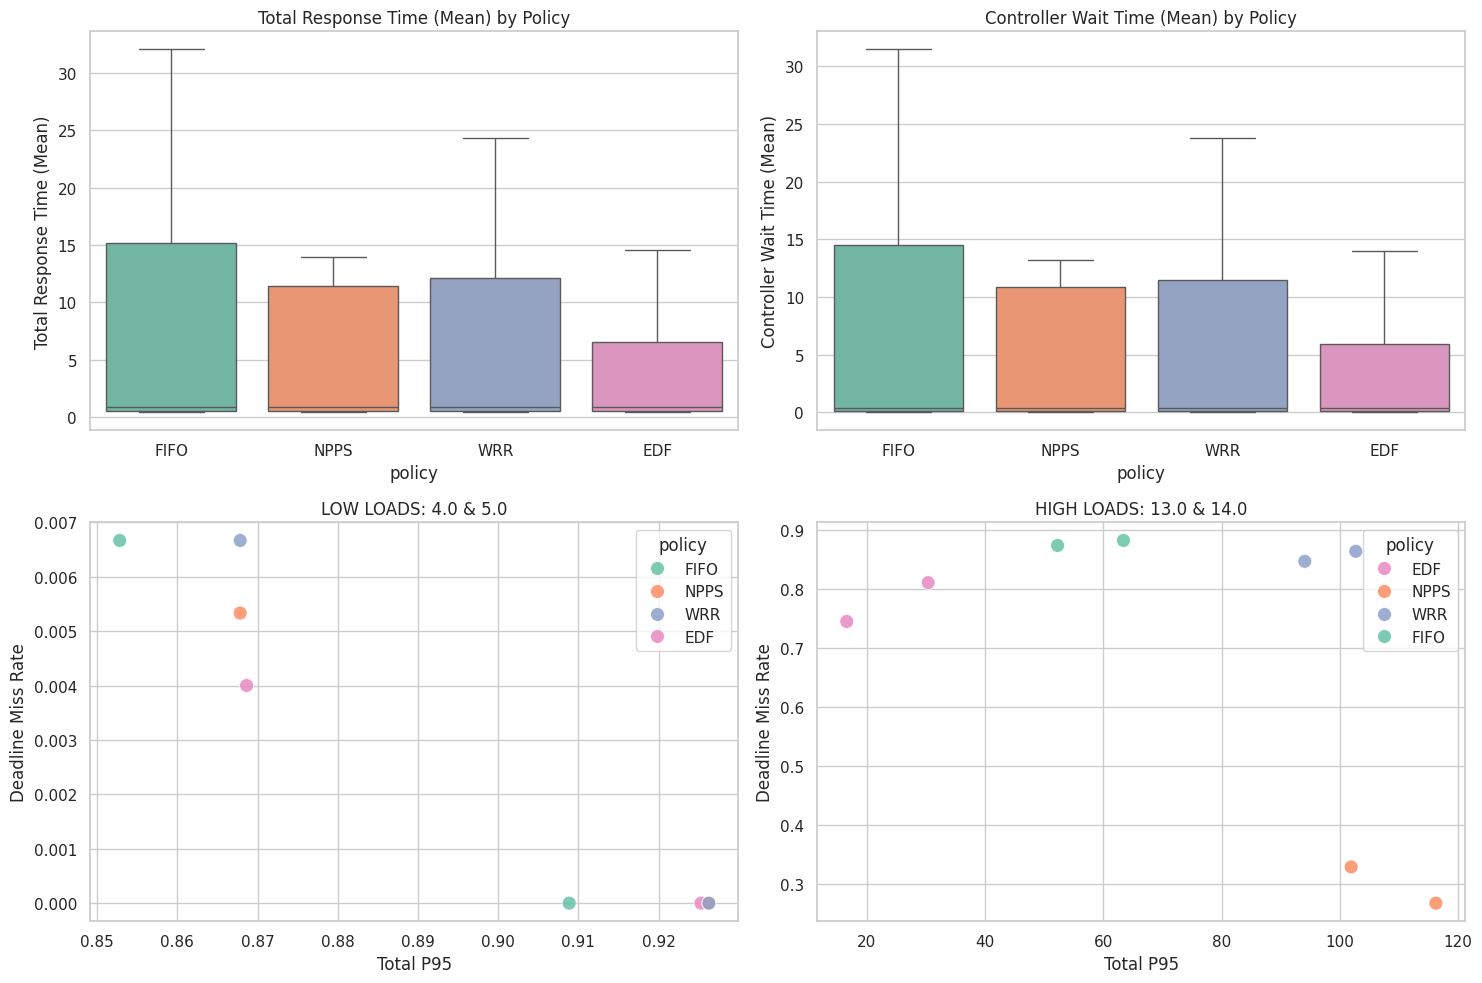

In [15]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 12)

df_plot = sweep_df.copy()

# Sort loads
loads_sorted = sorted(df_plot["chi_arrival"].unique())
low_loads = loads_sorted[:2]
high_loads = loads_sorted[-2:]

palette = {
    "FIFO": "#66c2a5",  # green
    "NPPS": "#fc8d62",  # orange
    "WRR":  "#8da0cb",  # light blue
    "EDF":  "#e78ac3"   # pink
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Total Response Time (Mean) Boxplot ---
sns.boxplot(
    x="policy", y="total_mean", hue="policy",
    data=df_plot, ax=axes[0,0], palette=palette, dodge=False
)
axes[0,0].set_title("Total Response Time (Mean) by Policy")
axes[0,0].set_ylabel("Total Response Time (Mean)")
legend = axes[0,0].get_legend()
if legend is not None:
    legend.remove()

# --- Controller Wait Time (Mean) Boxplot ---
sns.boxplot(
    x="policy", y="wait_ctrl_mean", hue="policy",
    data=df_plot, ax=axes[0,1], palette=palette, dodge=False
)
axes[0,1].set_title("Controller Wait Time (Mean) by Policy")
axes[0,1].set_ylabel("Controller Wait Time (Mean)")
legend = axes[0,1].get_legend()
if legend is not None:
    legend.remove()

# --- Scatter LOW loads ---
df_low = df_plot[df_plot["chi_arrival"].isin(low_loads)].copy().reset_index(drop=True)
if not df_low.empty:
    sns.scatterplot(
        x="total_p95", y="deadline_miss_rate",
        hue="policy", palette=palette, data=df_low, ax=axes[1,0],
        s=100, alpha=0.85, edgecolor="w", linewidth=0.6
    )
    axes[1,0].set_title(f"LOW LOADS: {low_loads[0]} & {low_loads[1]}")
    axes[1,0].set_xlabel("Total P95")
    axes[1,0].set_ylabel("Deadline Miss Rate")
    axes[1,0].grid(True)
else:
    axes[1,0].text(0.5,0.5,"No data for low loads", ha="center", va="center")

# --- Scatter HIGH loads ---
df_high = df_plot[df_plot["chi_arrival"].isin(high_loads)].copy().reset_index(drop=True)
if not df_high.empty:
    sns.scatterplot(
        x="total_p95", y="deadline_miss_rate",
        hue="policy", palette=palette, data=df_high, ax=axes[1,1],
        s=100, alpha=0.85, edgecolor="w", linewidth=0.6
    )
    axes[1,1].set_title(f"HIGH LOADS: {high_loads[-2]} & {high_loads[-1]}")
    axes[1,1].set_xlabel("Total P95")
    axes[1,1].set_ylabel("Deadline Miss Rate")
    axes[1,1].grid(True)
else:
    axes[1,1].text(0.5,0.5,"No data for high loads", ha="center", va="center")

plt.tight_layout()
plt.show()


In [16]:
# === Resource-side scheduling (policy-aware PV/BAT/GRID) ===
# Replaces ResourceServer and ResourcePool with policy-aware queues.
# Uses cfg.res_policy if present; defaults to FIFO. For WRR, uses cfg.res_wrr_weights or group_priority.

def _get_res_policy(cfg: SimConfig) -> PolicyType:
    return getattr(cfg, "res_policy", PolicyType.FIFO)

def _get_res_wrr_weights(cfg: SimConfig) -> Dict[str, float]:
    # default: weights proportional to group_priority
    return getattr(cfg, "res_wrr_weights", {g: float(p) for g, p in cfg.group_priority.items()})

class ResourceServer:
    """Single-server M/M/1 resource with pluggable queue policy (FIFO/NPPS/EDF/WRR)."""
    def __init__(self, name: str, rate: float, setup_delay: float,
                 policy: PolicyType, wrr_weights: Optional[Dict[str, float]] = None):
        self.name = name
        self.rate = rate
        self.setup_delay = setup_delay
        # build a queue with chosen policy
        if policy == PolicyType.WRR:
            if not wrr_weights:
                wrr_weights = {"essential": 3.0, "delay_sensitive": 2.0, "delay_tolerant": 1.0}
            self.queue = make_queue(PolicyType.WRR, wrr_weights=wrr_weights)
        else:
            self.queue = make_queue(policy)
        self.busy_until: Time = 0.0
        self.in_service: Optional[Request] = None

    def push(self, req: Request):
        self.queue.push(req)

    def try_start(self, now: Time, evq: List[Event]):
        if self.in_service is not None:
            return False
        if len(self.queue) > 0 and self.busy_until <= now:
            req = self.queue.pop(now)
            if req is None:
                return False
            req.t_res_start = now
            svc = rng.exponential(1.0 / self.rate) + self.setup_delay
            finish = now + svc
            self.busy_until = finish
            self.in_service = req
            heapq.heappush(evq, Event(finish, EventType.RES_FINISH, {"res": self.name, "req": req}))
            return True
        return False

    def on_finish(self, now: Time):
        req = self.in_service
        if req:
            req.t_res_end = now
        self.in_service = None
        self.busy_until = now

class ResourcePool:
    """Holds all resources and routes requests; now policy-aware per resource."""
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        res_policy = _get_res_policy(cfg)
        wrr_weights = _get_res_wrr_weights(cfg) if res_policy == PolicyType.WRR else None
        self.resources: Dict[str, ResourceServer] = {
            rname: ResourceServer(
                rname,
                rate=lambda_rate,
                setup_delay=cfg.setup_delay,
                policy=res_policy,
                wrr_weights=wrr_weights
            )
            for rname, lambda_rate in cfg.lambda_res.items()
        }

    def route_choice(self) -> str:
        names = list(self.cfg.route_probs.keys())
        probs = np.array(list(self.cfg.route_probs.values()))
        return rng.choice(names, p=probs)

    def on_ctrl_finish(self, req: Request, now: Time, evq: List[Event]):
        rname = self.route_choice()
        req.routed_to = rname
        req.t_ctrl_end = now
        overhead = self.cfg.transfer_overhead.get(rname, 0.0)
        arrival_at_res = now + overhead
        req.t_route_done = arrival_at_res
        heapq.heappush(evq, Event(arrival_at_res, EventType.RES_ARRIVAL, {"res": rname, "req": req}))

    def on_res_arrival(self, rname: str, req: Request, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.push(req)
        res.try_start(now, evq)

    def on_res_finish(self, rname: str, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.on_finish(now)
        res.try_start(now, evq)


In [17]:
# keep your controller policy as you like, e.g. EDF to reduce misses:
cfg.ctrl_policy = PolicyType.EDF

# pick a resource policy (default was FIFO). try EDF to propagate deadlines:
cfg.res_policy = PolicyType.EDF
# or NPPS to keep group priorities through the resources:
# cfg.res_policy = PolicyType.NPPS
# or WRR with custom weights (optional):
# cfg.res_policy = PolicyType.WRR
# cfg.res_wrr_weights = {"essential": 3, "delay_sensitive": 2, "delay_tolerant": 1}

df = run_simulation(cfg, group_mix)
overall, per_group, miss = summarize_metrics(df)
rep = utilization_report(cfg, df)
dash = deadline_dashboard(df)
display(overall, miss, rep)


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.190625,0.146467,0.473038
svc_res,1938.0,0.145558,0.105123,0.383167
total_response,1938.0,0.667422,0.474160,1.700300
transfer,1938.0,0.019185,0.020000,0.030000
wait_ctrl,1938.0,0.216612,0.043825,1.045168
wait_res,1938.0,0.095443,0.000000,0.529995


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,748,0,0.000000
__OVERALL__,1554,1551,3,0.001931


,unit,rho,busy_time,servers,rho_clipped,warning
0,CONTROLLER,0.769650,369.432081,2,0.769650,
1,RES::PV,0.567352,136.164376,1,0.567352,
2,RES::BAT,0.276141,66.273762,1,0.276141,
3,RES::GRID,0.331887,79.652946,1,0.331887,


In [18]:
bef_df = run_simulation(cfg, group_mix)
bef_overall, bef_per_group, bef_miss = summarize_metrics(bef_df)
bef_rep = utilization_report(cfg, bef_df)
bef_dash = deadline_dashboard(bef_df)
print("===== Simulation Report =====")
print(f" Controller Policy: {cfg.ctrl_policy.name}")
print(f" Resource Policy  : FIFO")
if cfg.res_policy == PolicyType.WRR:
    print(f" WRR Weights      : {cfg.res_wrr_weights}")

print("\n--- Overall Metrics ---")
display(bef_overall)

print("\n--- Deadline Misses ---")
display(bef_miss)

print("\n--- Utilization Report ---")
display(bef_rep)

print("\n--- Per Group Metrics ---")
display(bef_per_group)

print("\n--- Deadline Dashboard ---")
display(bef_dash)

===== Simulation Report =====
 Controller Policy: EDF
 Resource Policy  : FIFO

--- Overall Metrics ---


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.190625,0.146467,0.473038
svc_res,1938.0,0.145558,0.105123,0.383167
total_response,1938.0,0.667422,0.474160,1.700300
transfer,1938.0,0.019185,0.020000,0.030000
wait_ctrl,1938.0,0.216612,0.043825,1.045168
wait_res,1938.0,0.095443,0.000000,0.529995



--- Deadline Misses ---


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,748,0,0.000000
__OVERALL__,1554,1551,3,0.001931



--- Utilization Report ---


,unit,rho,busy_time,servers,rho_clipped,warning
0,CONTROLLER,0.769650,369.432081,2,0.769650,
1,RES::PV,0.567352,136.164376,1,0.567352,
2,RES::BAT,0.276141,66.273762,1,0.276141,
3,RES::GRID,0.331887,79.652946,1,0.331887,



--- Per Group Metrics ---


count/valid      mean    median       p95
group                                                                    
delay_sensitive wait_ctrl             806.0  0.083763  0.037985  0.321586
                svc_ctrl              806.0  0.193281  0.147223  0.485745
                transfer              806.0  0.018958  0.020000  0.030000
                wait_res              806.0  0.043756  0.000000  0.256882
                svc_res               806.0  0.144239  0.102928  0.371070
                total_response        806.0  0.483997  0.427362  1.004700
delay_tolerant  wait_ctrl             748.0  0.186944  0.042372  0.928582
                svc_ctrl              748.0  0.188723  0.146030  0.456687
                transfer              748.0  0.019278  0.020000  0.030000
                wait_res              748.0  0.112937  0.000000  0.579950
                svc_res               748.0  0.146205  0.105552  0.388238
                total_response        748.0  0.654087  0.493799  1.583485
essential       wait_ctrl             384.0  0.553247  0.089298  2.707822
                svc_ctrl              384.0  0.188757  0.145003  0.470942
                transfer              384.0  0.019479  0.020000  0.030000
                wait_res              384.0  0.169851  0.000000  0.972524
                svc_res               384.0  0.147066  0.109417  0.399239
                total_response        384.0  1.078400  0.623166  3.737920


--- Deadline Dashboard ---


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,748,0,0.000000
__OVERALL__,1554,1551,3,0.001931


In [19]:
cfg.ctrl_policy = PolicyType.EDF

cfg.res_policy = PolicyType.EDF

df = run_simulation(cfg, group_mix)
overall, per_group, miss = summarize_metrics(df)
rep = utilization_report(cfg, df)
dash = deadline_dashboard(df)

print("===== Simulation Report =====")
print(f" Controller Policy: {cfg.ctrl_policy.name}")
print(f" Resource Policy  : {cfg.res_policy.name}")
if cfg.res_policy == PolicyType.WRR:
    print(f" WRR Weights      : {cfg.res_wrr_weights}")

print("\n--- Overall Metrics ---")
display(overall)

print("\n--- Deadline Misses ---")
display(miss)

print("\n--- Utilization Report ---")
display(rep)

print("\n--- Per Group Metrics ---")
display(per_group)

print("\n--- Deadline Dashboard ---")
display(dash)


===== Simulation Report =====
 Controller Policy: EDF
 Resource Policy  : EDF

--- Overall Metrics ---


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.190625,0.146467,0.473038
svc_res,1938.0,0.145558,0.105123,0.383167
total_response,1938.0,0.667422,0.474160,1.700300
transfer,1938.0,0.019185,0.020000,0.030000
wait_ctrl,1938.0,0.216612,0.043825,1.045168
wait_res,1938.0,0.095443,0.000000,0.529995



--- Deadline Misses ---


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,748,0,0.000000
__OVERALL__,1554,1551,3,0.001931



--- Utilization Report ---


,unit,rho,busy_time,servers,rho_clipped,warning
0,CONTROLLER,0.769650,369.432081,2,0.769650,
1,RES::PV,0.567352,136.164376,1,0.567352,
2,RES::BAT,0.276141,66.273762,1,0.276141,
3,RES::GRID,0.331887,79.652946,1,0.331887,



--- Per Group Metrics ---


count/valid      mean    median       p95
group                                                                    
delay_sensitive wait_ctrl             806.0  0.083763  0.037985  0.321586
                svc_ctrl              806.0  0.193281  0.147223  0.485745
                transfer              806.0  0.018958  0.020000  0.030000
                wait_res              806.0  0.043756  0.000000  0.256882
                svc_res               806.0  0.144239  0.102928  0.371070
                total_response        806.0  0.483997  0.427362  1.004700
delay_tolerant  wait_ctrl             748.0  0.186944  0.042372  0.928582
                svc_ctrl              748.0  0.188723  0.146030  0.456687
                transfer              748.0  0.019278  0.020000  0.030000
                wait_res              748.0  0.112937  0.000000  0.579950
                svc_res               748.0  0.146205  0.105552  0.388238
                total_response        748.0  0.654087  0.493799  1.583485
essential       wait_ctrl             384.0  0.553247  0.089298  2.707822
                svc_ctrl              384.0  0.188757  0.145003  0.470942
                transfer              384.0  0.019479  0.020000  0.030000
                wait_res              384.0  0.169851  0.000000  0.972524
                svc_res               384.0  0.147066  0.109417  0.399239
                total_response        384.0  1.078400  0.623166  3.737920


--- Deadline Dashboard ---


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,748,0,0.000000
__OVERALL__,1554,1551,3,0.001931


# 4.1

In [20]:
# === Outage events for resources (MTBF/MTTR or fixed blocks) ===

# extend event types
class EventType(Enum):
    ARRIVAL = auto()
    CTRL_FINISH = auto()
    RES_ARRIVAL = auto()
    RES_FINISH = auto()
    OUTAGE_DOWN = auto()
    OUTAGE_UP = auto()

@dataclass(order=True)
class Event:
    time: Time
    etype: EventType
    payload: dict = field(compare=False)

def _get_res_policy(cfg: SimConfig) -> PolicyType:
    return getattr(cfg, "res_policy", PolicyType.FIFO)

def _get_res_wrr_weights(cfg: SimConfig) -> Dict[str, float]:
    return getattr(cfg, "res_wrr_weights", {g: float(p) for g, p in cfg.group_priority.items()})

class ResourceServer:
    """
    Single-server M/M/1 resource with policy-aware queue + outage handling.
    If an outage occurs during service, we 'pause' and resume on UP.
    Uses an 'epoch' to invalidate stale RES_FINISH events.
    """
    def __init__(self, name: str, rate: float, setup_delay: float,
                 policy: PolicyType, wrr_weights: Optional[Dict[str, float]] = None):
        self.name = name
        self.rate = rate
        self.setup_delay = setup_delay
        # queue policy
        if policy == PolicyType.WRR:
            if not wrr_weights:
                wrr_weights = {"essential": 3.0, "delay_sensitive": 2.0, "delay_tolerant": 1.0}
            self.queue = make_queue(PolicyType.WRR, wrr_weights=wrr_weights)
        else:
            self.queue = make_queue(policy)
        # state
        self.available: bool = True
        self.busy_until: Time = 0.0
        self.in_service: Optional[Request] = None
        self.paused_remaining: Optional[float] = None
        self.epoch: int = 0  # increments on DOWN/UP to kill stale finish events

    def push(self, req: Request):
        self.queue.push(req)

    def try_start(self, now: Time, evq: List[Event]):
        if not self.available:
            return False
        if self.in_service is not None:
            return False
        if len(self.queue) == 0 or self.busy_until > now:
            return False
        # start fresh service
        req = self.queue.pop(now)
        if req is None:
            return False
        req.t_res_start = now
        svc = rng.exponential(1.0 / self.rate) + self.setup_delay
        finish = now + svc
        self.busy_until = finish
        self.in_service = req
        heapq.heappush(evq, Event(finish, EventType.RES_FINISH,
                                  {"res": self.name, "req": req, "epoch": self.epoch}))
        return True

    def on_finish(self, now: Time, ev: Event):
        # ignore stale finishes from a previous epoch (e.g., outage happened)
        if ev.payload.get("epoch", self.epoch) != self.epoch:
            return
        if not self.available:
            return  # should not happen for matching epoch, but guard anyway
        req = self.in_service
        if req:
            req.t_res_end = now
        self.in_service = None
        self.busy_until = now

    # --- outage handling ---
    def on_outage_down(self, now: Time):
        if not self.available:
            return
        self.available = False
        # invalidate in-flight finish events
        self.epoch += 1
        if self.in_service is not None:
            # compute remaining and pause
            remaining = max(0.0, self.busy_until - now)
            self.paused_remaining = remaining
            # mark server as free at 'now' but keep req in_service to resume
            self.busy_until = now

    def on_outage_up(self, now: Time, evq: List[Event]):
        if self.available:
            return
        self.available = True
        # new epoch for finishes after UP
        self.epoch += 1
        # resume paused service if any
        if self.in_service is not None and self.paused_remaining is not None:
            finish = now + self.paused_remaining
            self.busy_until = finish
            heapq.heappush(evq, Event(finish, EventType.RES_FINISH,
                                      {"res": self.name, "req": self.in_service, "epoch": self.epoch}))
            self.paused_remaining = None
        else:
            # try to start next job
            self.try_start(now, evq)

class ResourcePool:
    """Policy-aware resources with outage support + fixed routing."""
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        res_policy = _get_res_policy(cfg)
        wrr_weights = _get_res_wrr_weights(cfg) if res_policy == PolicyType.WRR else None
        self.resources: Dict[str, ResourceServer] = {
            rname: ResourceServer(
                rname, rate=lambda_rate, setup_delay=cfg.setup_delay,
                policy=res_policy, wrr_weights=wrr_weights
            )
            for rname, lambda_rate in cfg.lambda_res.items()
        }

    def route_choice(self) -> str:
        names = list(self.cfg.route_probs.keys())
        probs = np.array(list(self.cfg.route_probs.values()))
        return rng.choice(names, p=probs)

    def on_ctrl_finish(self, req: Request, now: Time, evq: List[Event]):
        rname = self.route_choice()
        req.routed_to = rname
        req.t_ctrl_end = now
        overhead = self.cfg.transfer_overhead.get(rname, 0.0)
        arrival_at_res = now + overhead
        req.t_route_done = arrival_at_res
        heapq.heappush(evq, Event(arrival_at_res, EventType.RES_ARRIVAL, {"res": rname, "req": req}))

    def on_res_arrival(self, rname: str, req: Request, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.push(req)
        res.try_start(now, evq)

    def on_res_finish(self, rname: str, now: Time, evq: List[Event], ev: Event):
        res = self.resources[rname]
        res.on_finish(now, ev)
        res.try_start(now, evq)

    def on_outage_down(self, rname: str, now: Time):
        self.resources[rname].on_outage_down(now)

    def on_outage_up(self, rname: str, now: Time, evq: List[Event]):
        self.resources[rname].on_outage_up(now, evq)

# --- outage plan utilities ---
def schedule_outages(outage_plan: Optional[Dict[str, dict]], evq: List[Event], T: float, seed: int = DEFAULT_SEED):
    """
    outage_plan example:
    {
      "PV": {"mtbf": 120.0, "mttr": 10.0},               # exponential up/down in minutes
      "BAT": {"blocks": [{"start": 90.0, "dur": 15.0}]},  # fixed blocks
    }
    """
    if not outage_plan:
        return
    local_rng = np.random.default_rng(seed + 12345)
    for rname, spec in outage_plan.items():
        if "blocks" in spec:
            for b in spec["blocks"]:
                s = float(b["start"]); d = float(b["dur"])
                if s < T:
                    heapq.heappush(evq, Event(s, EventType.OUTAGE_DOWN, {"res": rname}))
                    if s + d < T:
                        heapq.heappush(evq, Event(s + d, EventType.OUTAGE_UP, {"res": rname}))
        else:
            # alternating UP (~Exp(mtbf)) and DOWN (~Exp(mttr)), starting in UP state
            mtbf = float(spec.get("mtbf", 0))
            mttr = float(spec.get("mttr", 0))
            if mtbf <= 0 or mttr <= 0:
                continue
            t = float(local_rng.exponential(mtbf))
            while t < T:
                heapq.heappush(evq, Event(t, EventType.OUTAGE_DOWN, {"res": rname}))
                t_up = t + float(local_rng.exponential(mttr))
                if t_up < T:
                    heapq.heappush(evq, Event(t_up, EventType.OUTAGE_UP, {"res": rname}))
                t = t_up + float(local_rng.exponential(mtbf))

# --- patch: run_simulation to accept outage_plan and pass events ---
def run_simulation(cfg: SimConfig, group_mix: Dict[str, float], outage_plan: Optional[Dict[str, dict]] = None) -> pd.DataFrame:
    cfg.validate()
    global rng
    rng = np.random.default_rng(cfg.seed)

    reqs = bootstrap_requests(cfg, group_mix)
    controller = MultiServerController(cfg)
    pool = ResourcePool(cfg)

    evq: List[Event] = []
    # arrivals
    for req in reqs:
        heapq.heappush(evq, Event(req.arrival_time, EventType.ARRIVAL, {"req": req}))
    # outages
    schedule_outages(outage_plan, evq, cfg.T, seed=cfg.seed)

    while evq:
        ev = heapq.heappop(evq)
        now = ev.time
        if now > cfg.T:
            break

        if ev.etype == EventType.ARRIVAL:
            controller.on_arrival(ev.payload["req"], now, evq)

        elif ev.etype == EventType.CTRL_FINISH:
            sid = ev.payload["sid"]
            req: Request = controller.on_finish(sid, now)
            pool.on_ctrl_finish(req, now, evq)
            controller.try_start_service(now, evq)

        elif ev.etype == EventType.RES_ARRIVAL:
            pool.on_res_arrival(ev.payload["res"], ev.payload["req"], now, evq)

        elif ev.etype == EventType.RES_FINISH:
            pool.on_res_finish(ev.payload["res"], now, evq, ev)

        elif ev.etype == EventType.OUTAGE_DOWN:
            pool.on_outage_down(ev.payload["res"], now)

        elif ev.etype == EventType.OUTAGE_UP:
            pool.on_outage_up(ev.payload["res"], now, evq)

    # assemble results (unchanged)
    finished: List[Request] = [r for r in reqs if r.t_res_end is not None]
    def safe(x): return None if x is None else float(x)
    rows = []
    for r in finished:
        wait_ctrl = (r.t_ctrl_start - r.arrival_time) if (r.t_ctrl_start is not None) else None
        svc_ctrl  = (r.t_ctrl_end - r.t_ctrl_start) if (r.t_ctrl_end is not None and r.t_ctrl_start is not None) else None
        transfer  = (r.t_route_done - r.t_ctrl_end) if (r.t_route_done is not None and r.t_ctrl_end is not None) else None
        wait_res  = (r.t_res_start - r.t_route_done) if (r.t_res_start is not None and r.t_route_done is not None) else None
        svc_res   = (r.t_res_end - r.t_res_start) if (r.t_res_end is not None and r.t_res_start is not None) else None
        total     = (r.t_res_end - r.arrival_time) if (r.t_res_end is not None) else None
        rows.append({
            "rid": r.rid, "group": r.group, "priority": r.priority,
            "arrival": safe(r.arrival_time), "deadline": safe(r.deadline_time),
            "ctrl_start": safe(r.t_ctrl_start), "ctrl_end": safe(r.t_ctrl_end),
            "routed_to": r.routed_to, "route_done": safe(r.t_route_done),
            "res_start": safe(r.t_res_start), "res_end": safe(r.t_res_end),
            "wait_ctrl": safe(wait_ctrl), "svc_ctrl": safe(svc_ctrl),
            "transfer": safe(transfer), "wait_res": safe(wait_res),
            "svc_res": safe(svc_res), "total_response": safe(total),
        })
    return pd.DataFrame(rows)


In [21]:
# no outages (baseline): df = run_simulation(cfg, group_mix)

# MTBF/MTTR style (minutes):
out_plan = {
    "PV":  {"mtbf": 120.0, "mttr": 10.0},
    "GRID":{"mtbf": 300.0, "mttr": 5.0},
    # fixed block outage:
    "BAT": {"blocks": [{"start": 90.0, "dur": 15.0}]}
}

df_out = run_simulation(cfg, group_mix, outage_plan=out_plan)
overall_out, pergrp_out, miss_out = summarize_metrics(df_out)
rep_out = utilization_report(cfg, df_out)
dash_out = deadline_dashboard(df_out)
display(overall_out, miss_out, rep_out)


,count/valid,mean,median,p95
svc_ctrl,1822.0,0.192702,0.150036,0.474089
svc_res,1822.0,0.174054,0.103755,0.376856
total_response,1822.0,2.972979,0.499020,27.181441
transfer,1822.0,0.018430,0.020000,0.030000
wait_ctrl,1822.0,0.204989,0.048707,0.963024
wait_res,1822.0,2.382805,0.000000,26.007008


,count,met,misses,miss_rate
delay_sensitive,773,682,91,0.117723
delay_tolerant,715,665,50,0.069930
__OVERALL__,1488,1347,141,0.094758


,unit,rho,busy_time,servers,rho_clipped,warning
0,CONTROLLER,0.731463,351.102175,2,0.731463,
1,RES::PV,0.696548,167.171550,1,0.696548,
2,RES::BAT,0.257343,61.762411,1,0.257343,
3,RES::GRID,0.367466,88.191778,1,0.367466,


# 4.2

In [22]:
# === 4.2: Policy+Config patches: HYBRID scheduler & routing modes ===

# extend PolicyType with HYBRID
class PolicyType(Enum):
    FIFO = auto()
    NPPS = auto()
    WRR  = auto()
    EDF  = auto()
    HYBRID = auto()   # new: score-based blend of EDF+Priority+Aging

from dataclasses import dataclass, field

@dataclass
class SimConfig:
    # --- required (no defaults) ---
    chi_arrival: float
    lambda_ctrl: float
    lambda_res: Dict[str, float]
    setup_delay: float
    T: Time
    N_ctrl: int
    transfer_overhead: Dict[str, float]
    route_probs: Dict[str, float]

    # --- existing defaults ---
    ctrl_policy: PolicyType = PolicyType.FIFO
    group_priority: Dict[str, int] = field(
        default_factory=lambda: {"essential": 3, "delay_sensitive": 2, "delay_tolerant": 1}
    )
    default_deadline_slots: Dict[str, Tuple[int,int]] = field(
        default_factory=lambda: {"delay_sensitive": (1,4), "delay_tolerant": (3,12)}
    )
    seed: int = DEFAULT_SEED

    # --- NEW (4.2) routing & hybrid knobs (all defaults) ---
    # resource-side policy (if you added the earlier resource policy cell)
    res_policy: PolicyType = PolicyType.FIFO
    res_wrr_weights: Optional[Dict[str, float]] = None

    # routing: "static" (use route_probs), "avail" (avoid DOWN resources),
    # "mct" (min completion time among AVAILABLE resources)
    routing_mode: Literal["static", "avail", "mct"] = "static"

    # HYBRID controller weights: score = α·urgency + β·priority + γ·aging
    hybrid_alpha: float = 1.0   # urgency = 1 / max(ε, deadline - now)  (no-deadline => 0)
    hybrid_beta:  float = 0.5   # priority weight (uses group_priority)
    hybrid_gamma: float = 0.1   # aging = (now - arrival_time)

    def validate(self):
        assert self.chi_arrival > 0
        assert self.lambda_ctrl > 0
        assert all(v > 0 for v in self.lambda_res.values())
        assert self.N_ctrl >= 1
        assert self.T > 0
        s = sum(self.route_probs.values())
        assert abs(s - 1.0) < 1e-8, f"route_probs must sum to 1 (got {s})"
        for r in self.transfer_overhead:
            assert r in self.lambda_res, f"transfer_overhead key {r} missing in lambda_res"
        for r in self.lambda_res:
            assert r in self.transfer_overhead, f"lambda_res key {r} missing in transfer_overhead"


In [23]:
# === 4.2: Hybrid score-based controller queue ===
class HybridQueue(BaseQueuePolicy):
    """
    Score(req, now) = α * urgency + β * priority + γ * aging
      urgency = 1 / max(eps, deadline - now)  (0 if no deadline)
      priority = int(req.priority)
      aging = now - arrival_time
    Higher score pops first. Ties -> FIFO by insertion order.
    """
    def __init__(self, alpha: float, beta: float, gamma: float):
        self.alpha = float(alpha)
        self.beta  = float(beta)
        self.gamma = float(gamma)
        self._store: List[Tuple[int, Request]] = []  # (arrival_idx, req)
        self._counter = 0

    def push(self, req: Request) -> None:
        self._counter += 1
        self._store.append((self._counter, req))

    def __len__(self) -> int:
        return len(self._store)

    @staticmethod
    def _urgency(req: Request, now: float, eps: float = 1e-6) -> float:
        if req.deadline_time is None:
            return 0.0
        rem = max(eps, req.deadline_time - now)
        return 1.0 / rem

    def pop(self, now: Time) -> Optional[Request]:
        if not self._store:
            return None
        # compute scores on the fly (O(n)), robust and simple for moderate queues
        best_idx = None
        best_score = -1e18
        for idx, (order, req) in enumerate(self._store):
            score = (
                self.alpha * self._urgency(req, now) +
                self.beta  * float(req.priority) +
                self.gamma * max(0.0, now - req.arrival_time)
            )
            if score > best_score:
                best_score = score
                best_idx = idx
        # pop best
        order, req = self._store.pop(best_idx)
        return req


In [24]:
# patch make_queue to include HYBRID (and WRR weights passthrough)
def make_queue(policy: PolicyType, *, wrr_weights: Optional[Dict[str, float]] = None,
               hybrid_params: Optional[Tuple[float,float,float]] = None) -> BaseQueuePolicy:
    if policy == PolicyType.FIFO: return FIFOQueue()
    if policy == PolicyType.NPPS: return NPPSQueue()
    if policy == PolicyType.EDF:  return EDFQueue()
    if policy == PolicyType.WRR:
        assert wrr_weights is not None and len(wrr_weights) > 0, "Provide wrr_weights"
        return WRRQueue(wrr_weights)
    if policy == PolicyType.HYBRID:
        assert hybrid_params is not None, "Provide (alpha,beta,gamma) for HYBRID"
        a,b,g = hybrid_params
        return HybridQueue(a,b,g)
    raise NotImplementedError(policy)

# patch controller to pass params for WRR / HYBRID
class MultiServerController:
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        if cfg.ctrl_policy == PolicyType.WRR:
            wrr_weights = {g: float(p) for g, p in cfg.group_priority.items()}
            self.queue = make_queue(cfg.ctrl_policy, wrr_weights=wrr_weights)
        elif cfg.ctrl_policy == PolicyType.HYBRID:
            self.queue = make_queue(cfg.ctrl_policy, hybrid_params=(cfg.hybrid_alpha, cfg.hybrid_beta, cfg.hybrid_gamma))
        else:
            self.queue = make_queue(cfg.ctrl_policy)
        self.server_busy_until: List[Time] = [0.0] * cfg.N_ctrl
        self.in_service: Dict[int, Request] = {}
    # (rest of class unchanged)


In [25]:
# === 4.2: Smarter routing modes ===
def _expected_service_time(rate: float, setup_delay: float) -> float:
    return (1.0 / rate) + setup_delay

def _predict_finish(res: "ResourceServer", now: float, es: float, transfer: float) -> float:
    # if down: treat as very large ETA
    if hasattr(res, "available") and not res.available:
        return float("inf")
    in_flight = max(0.0, getattr(res, "busy_until", now) - now)
    qlen = len(res.queue) if hasattr(res, "queue") else 0
    return now + transfer + in_flight + qlen * es

class ResourcePool:
    """Policy-aware resources with outage support + smarter routing."""
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        res_policy = getattr(cfg, "res_policy", PolicyType.FIFO)
        wrr_weights = cfg.res_wrr_weights if (res_policy == PolicyType.WRR) else None
        if res_policy == PolicyType.WRR and not wrr_weights:
            wrr_weights = {g: float(p) for g,p in cfg.group_priority.items()}
        self.resources: Dict[str, ResourceServer] = {
            rname: ResourceServer(
                rname, rate=lambda_rate, setup_delay=cfg.setup_delay,
                policy=res_policy, wrr_weights=wrr_weights
            )
            for rname, lambda_rate in cfg.lambda_res.items()
        }

    def route_choice_static(self) -> str:
        names = list(self.cfg.route_probs.keys())
        probs = np.array(list(self.cfg.route_probs.values()))
        return rng.choice(names, p=probs)

    def route_choice_mct(self, now: float) -> str:
        best_r = None
        best_eta = float("inf")
        for rname, res in self.resources.items():
            es = _expected_service_time(self.cfg.lambda_res[rname], self.cfg.setup_delay)
            tr = self.cfg.transfer_overhead.get(rname, 0.0)
            eta = _predict_finish(res, now, es, tr)
            if eta < best_eta:
                best_eta = eta
                best_r = rname
        # fallback if all are down (eta=inf): choose the least-bad (GRID preferred if present)
        if best_r is None or best_eta == float("inf"):
            return "GRID" if "GRID" in self.resources else self.route_choice_static()
        return best_r

    def route_choice(self, now: float) -> str:
        mode = getattr(self.cfg, "routing_mode", "static")
        if mode == "static":
            return self.route_choice_static()
        elif mode == "avail":
            # choose statically among AVAILABLE only; fallback to GRID
            avail = [r for r, res in self.resources.items() if getattr(res, "available", True)]
            if not avail:
                return "GRID" if "GRID" in self.resources else self.route_choice_static()
            names = avail
            probs = np.array([self.cfg.route_probs.get(n, 0.0) for n in names], dtype=float)
            if probs.sum() <= 0:
                probs = np.ones(len(names)) / len(names)
            else:
                probs = probs / probs.sum()
            return rng.choice(names, p=probs)
        elif mode == "mct":
            return self.route_choice_mct(now)
        else:
            return self.route_choice_static()

    def on_ctrl_finish(self, req: Request, now: Time, evq: List[Event]):
        rname = self.route_choice(now)
        req.routed_to = rname
        req.t_ctrl_end = now
        overhead = self.cfg.transfer_overhead.get(rname, 0.0)
        arrival_at_res = now + overhead
        req.t_route_done = arrival_at_res
        heapq.heappush(evq, Event(arrival_at_res, EventType.RES_ARRIVAL, {"res": rname, "req": req}))

    # the rest (on_res_arrival, on_res_finish, outage handlers) stay the same
    def on_res_arrival(self, rname: str, req: Request, now: Time, evq: List[Event]):
        res = self.resources[rname]
        res.push(req)
        res.try_start(now, evq)

    def on_res_finish(self, rname: str, now: Time, evq: List[Event], ev: Event):
        res = self.resources[rname]
        if hasattr(res, "on_finish"):
            res.on_finish(now, ev)
        else:
            # legacy finish (no outage epoch)
            req = res.in_service
            if req:
                req.t_res_end = now
            res.in_service = None
            res.busy_until = now
        res.try_start(now, evq)

    def on_outage_down(self, rname: str, now: Time):
        res = self.resources[rname]
        if hasattr(res, "on_outage_down"):
            res.on_outage_down(now)

    def on_outage_up(self, rname: str, now: Time, evq: List[Event]):
        res = self.resources[rname]
        if hasattr(res, "on_outage_up"):
            res.on_outage_up(now, evq)


In [26]:
# === Restore controller + queue factory (HYBRID/WRR aware) ===

def make_queue(policy: PolicyType, *, wrr_weights: Optional[Dict[str, float]] = None,
               hybrid_params: Optional[Tuple[float,float,float]] = None) -> BaseQueuePolicy:
    if policy == PolicyType.FIFO:
        return FIFOQueue()
    if policy == PolicyType.NPPS:
        return NPPSQueue()
    if policy == PolicyType.EDF:
        return EDFQueue()
    if policy == PolicyType.WRR:
        assert wrr_weights is not None and len(wrr_weights) > 0, "Provide wrr_weights"
        return WRRQueue(wrr_weights)
    if policy == PolicyType.HYBRID:
        assert hybrid_params is not None, "Provide (alpha,beta,gamma) for HYBRID"
        a, b, g = hybrid_params
        return HybridQueue(a, b, g)
    raise NotImplementedError(policy)

class MultiServerController:
    """Controller M/M/N with pluggable queue (FIFO/NPPS/EDF/WRR/HYBRID)."""
    def __init__(self, cfg: SimConfig):
        self.cfg = cfg
        if cfg.ctrl_policy == PolicyType.WRR:
            wrr_weights = {g: float(p) for g, p in cfg.group_priority.items()}
            self.queue = make_queue(cfg.ctrl_policy, wrr_weights=wrr_weights)
        elif cfg.ctrl_policy == PolicyType.HYBRID:
            self.queue = make_queue(
                cfg.ctrl_policy,
                hybrid_params=(cfg.hybrid_alpha, cfg.hybrid_beta, cfg.hybrid_gamma),
            )
        else:
            self.queue = make_queue(cfg.ctrl_policy)

        self.server_busy_until: List[Time] = [0.0] * cfg.N_ctrl
        self.in_service: Dict[int, Request] = {}

    def _first_free_server(self, now: Time) -> Optional[int]:
        for sid, busy_until in enumerate(self.server_busy_until):
            if busy_until <= now and self.in_service.get(sid) is None:
                return sid
        return None

    def try_start_service(self, now: Time, evq: List["Event"]):
        started = 0
        while True:
            sid = self._first_free_server(now)
            if sid is None:
                break
            req = self.queue.pop(now)
            if req is None:
                break
            req.t_ctrl_start = now
            svc = rng.exponential(1.0 / self.cfg.lambda_ctrl) + self.cfg.setup_delay
            finish = now + svc
            self.server_busy_until[sid] = finish
            self.in_service[sid] = req
            heapq.heappush(evq, Event(finish, EventType.CTRL_FINISH, {"sid": sid, "req": req}))
            started += 1
        return started

    def on_arrival(self, req: Request, now: Time, evq: List["Event"]):
        self.queue.push(req)
        self.try_start_service(now, evq)

    def on_finish(self, sid: int, now: Time) -> Request:
        self.server_busy_until[sid] = now
        return self.in_service.pop(sid)


In [27]:
# Choose the hybrid controller + smarter routing:
cfg.ctrl_policy = PolicyType.HYBRID
cfg.hybrid_alpha, cfg.hybrid_beta, cfg.hybrid_gamma = 1.0, 0.6, 0.1   # a good starting point

cfg.routing_mode = "mct"      # try: "avail" or "mct" (min completion time among available)
# Optional: propagate deadlines/priority at resources too:
cfg.res_policy = PolicyType.EDF    # or NPPS / WRR (with cfg.res_wrr_weights)

df_opt = run_simulation(cfg, group_mix, outage_plan=out_plan)   # use your 4.1 outage plan
overall_opt, pergrp_opt, miss_opt = summarize_metrics(df_opt)
rep_opt = utilization_report(cfg, df_opt)
dash_opt = deadline_dashboard(df_opt)
display(overall_opt, miss_opt, rep_opt)


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.187401,0.144921,0.466870
svc_res,1938.0,0.131502,0.092656,0.269606
total_response,1938.0,0.557238,0.403346,1.424545
transfer,1938.0,0.014474,0.010000,0.030000
wait_ctrl,1938.0,0.183309,0.044006,0.836794
wait_res,1938.0,0.040552,0.000000,0.143563


,count,met,misses,miss_rate
delay_sensitive,805,803,2,0.002484
delay_tolerant,749,749,0,0.000000
__OVERALL__,1554,1552,2,0.001287


,unit,rho,busy_time,servers,rho_clipped,warning
0,CONTROLLER,0.756631,363.182934,2,0.756631,
1,RES::PV,0.224451,53.868290,1,0.224451,
2,RES::BAT,0.297420,71.380729,1,0.297420,
3,RES::GRID,0.540010,129.602465,1,0.540010,


# Performance Summary

### ⏱ Delays
- **Mean total delay:** ≈ **0.56 min**  
- **95th percentile (p95):** ≈ **1.42 min**  
- Huge improvement vs. outage baseline (**mean ≈ 2.97**, **p95 ≈ 27!**)

---

### 🚦 Bottlenecks relieved
- **wait_res_mean:** 0.04 (was **2.38**) → **major relief**  
- **Controller utilization (ρ):** ≈ **0.76** → **healthy**

---

### 📅 Deadlines
- **Overall miss rate:** **0.13%**  
- **Delay-sensitive miss rate:** **0.25%**  
- → Excellent even under outage conditions

---

### 🔀 Routing Behavior
- Load **shifted to GRID** (ρ ≈ **0.54**)  
- PV remains **light** (ρ ≈ **0.22**)  
- **Transfer mean:** ↓ to **0.0145** → consistent with **lower-overhead paths** (likely due to **MCT routing**)


In [28]:
# === Energy accounting: demand_kwh, cost/carbon, and summaries ===
from dataclasses import dataclass
from typing import Optional

# 1) Re-define Request to include demand_kwh (default 1.0 kWh)
@dataclass
class Request:
    rid: ID
    group: str
    priority: int
    arrival_time: Time
    deadline_time: Optional[Time] = None
    demand_kwh: float = 1.0   # <--- NEW

    # timestamps
    t_ctrl_start: Optional[Time] = None
    t_ctrl_end:   Optional[Time] = None
    routed_to:    Optional[str]  = None
    t_route_done: Optional[Time] = None
    t_res_start:  Optional[Time] = None
    t_res_end:    Optional[Time] = None

# 2) Helpers for kWh sampling and resource labeling (all overrideable via cfg)
def _get_demand_profiles(cfg: SimConfig):
    # mean kWh and coefficient of variation (cv) per group (lognormal)
    return getattr(cfg, "demand_kwh_profiles", {
        "essential":       {"mean": 2.0, "cv": 0.25},
        "delay_sensitive": {"mean": 1.5, "cv": 0.30},
        "delay_tolerant":  {"mean": 1.0, "cv": 0.35},
    })

def _sample_demand_kwh(cfg: SimConfig, group: str) -> float:
    profs = _get_demand_profiles(cfg)
    p = profs.get(group, {"mean": 1.0, "cv": 0.3})
    mean, cv = float(p["mean"]), float(p["cv"])
    # lognormal params from mean & cv
    # mean = exp(mu + 0.5*sigma^2),  cv^2 = exp(sigma^2) - 1
    sigma2 = np.log(cv*cv + 1.0)
    sigma = np.sqrt(sigma2)
    mu = np.log(mean) - 0.5 * sigma2
    kwh = float(np.random.lognormal(mean=mu, sigma=sigma))
    return max(0.05, kwh)  # clip tiny

def _renewable_sets(cfg: SimConfig):
    ren = set(getattr(cfg, "renewable_sources", {"PV"}))
    non = set(getattr(cfg, "nonrenewable_sources", {"GRID"}))
    sto = set(getattr(cfg, "storage_sources", {"BAT"}))
    return ren, non, sto

def _energy_costs(cfg: SimConfig):
    # simple default $/kWh (or any unit): PV cheap, BAT small overhead, GRID higher
    return getattr(cfg, "energy_cost", {"PV": 0.02, "BAT": 0.03, "GRID": 0.18})

def _carbon_intensity(cfg: SimConfig):
    # kg CO2e / kWh defaults: PV ~0, BAT small (round-trip overhead), GRID moderate
    return getattr(cfg, "carbon_intensity", {"PV": 0.0, "BAT": 0.05, "GRID": 0.4})

# 3) Patch: deadline-aware bootstrap now attaches demand_kwh
def bootstrap_requests(cfg: SimConfig, group_mix: Dict[str, float]) -> List[Request]:
    assert abs(sum(group_mix.values()) - 1.0) < 1e-8, "group_mix must sum to 1"
    t = 0.0
    rid = 0
    reqs: List[Request] = []
    groups = list(group_mix.keys())
    probs  = np.array(list(group_mix.values()))
    while t < cfg.T:
        t = generate_next_arrival(t, cfg.chi_arrival)
        if t >= cfg.T: break
        g = rng.choice(groups, p=probs)
        pr = cfg.group_priority.get(g, 1)
        dl = _sample_deadline_for_group(cfg, g, t)
        kwh = _sample_demand_kwh(cfg, g)
        reqs.append(Request(
            rid=rid, group=g, priority=pr,
            arrival_time=t, deadline_time=dl,
            demand_kwh=kwh
        ))
        rid += 1
    return reqs

# 4) Patch: run_simulation to emit energy columns
def run_simulation(cfg: SimConfig, group_mix: Dict[str, float], outage_plan: Optional[Dict[str, dict]] = None) -> pd.DataFrame:
    cfg.validate()
    global rng
    rng = np.random.default_rng(cfg.seed)

    reqs = bootstrap_requests(cfg, group_mix)
    controller = MultiServerController(cfg)
    pool = ResourcePool(cfg)

    evq: List[Event] = []
    # arrivals
    for req in reqs:
        heapq.heappush(evq, Event(req.arrival_time, EventType.ARRIVAL, {"req": req}))
    # outages (if any)
    if 'schedule_outages' in globals():
        schedule_outages(outage_plan, evq, cfg.T, seed=cfg.seed)

    while evq:
        ev = heapq.heappop(evq)
        now = ev.time
        if now > cfg.T: break

        if ev.etype == EventType.ARRIVAL:
            controller.on_arrival(ev.payload["req"], now, evq)

        elif ev.etype == EventType.CTRL_FINISH:
            sid = ev.payload["sid"]
            req: Request = controller.on_finish(sid, now)
            pool.on_ctrl_finish(req, now, evq)
            controller.try_start_service(now, evq)

        elif ev.etype == EventType.RES_ARRIVAL:
            pool.on_res_arrival(ev.payload["res"], ev.payload["req"], now, evq)

        elif ev.etype == EventType.RES_FINISH:
            # handle both outage-aware and legacy pools
            if "epoch" in ev.payload or hasattr(pool, "on_outage_down"):
                pool.on_res_finish(ev.payload["res"], now, evq, ev)
            else:
                rname = ev.payload["res"]
                res = pool.resources[rname]
                req = res.in_service
                if req:
                    req.t_res_end = now
                res.in_service = None
                res.busy_until = now
                res.try_start(now, evq)

        elif hasattr(EventType, "OUTAGE_DOWN") and ev.etype == EventType.OUTAGE_DOWN:
            pool.on_outage_down(ev.payload["res"], now)

        elif hasattr(EventType, "OUTAGE_UP") and ev.etype == EventType.OUTAGE_UP:
            pool.on_outage_up(ev.payload["res"], now, evq)

    # assemble results (+ energy)
    cost_map = _energy_costs(cfg)
    carbon_map = _carbon_intensity(cfg)

    finished: List[Request] = [r for r in reqs if r.t_res_end is not None]
    def safe(x): return None if x is None else float(x)

    rows = []
    for r in finished:
        wait_ctrl = (r.t_ctrl_start - r.arrival_time) if (r.t_ctrl_start is not None) else None
        svc_ctrl  = (r.t_ctrl_end - r.t_ctrl_start) if (r.t_ctrl_end is not None and r.t_ctrl_start is not None) else None
        transfer  = (r.t_route_done - r.t_ctrl_end) if (r.t_route_done is not None and r.t_ctrl_end is not None) else None
        wait_res  = (r.t_res_start - r.t_route_done) if (r.t_res_start is not None and r.t_route_done is not None) else None
        svc_res   = (r.t_res_end - r.t_res_start) if (r.t_res_end is not None and r.t_res_start is not None) else None
        total     = (r.t_res_end - r.arrival_time) if (r.t_res_end is not None) else None

        res = r.routed_to or "UNKNOWN"
        kwh = float(getattr(r, "demand_kwh", 1.0))
        energy_cost = kwh * float(cost_map.get(res, 0.0))
        carbon_kg   = kwh * float(carbon_map.get(res, 0.0))

        rows.append({
            "rid": r.rid,
            "group": r.group,
            "priority": r.priority,
            "arrival": safe(r.arrival_time),
            "deadline": safe(r.deadline_time),
            "kwh": kwh,
            "ctrl_start": safe(r.t_ctrl_start),
            "ctrl_end": safe(r.t_ctrl_end),
            "routed_to": res,
            "route_done": safe(r.t_route_done),
            "res_start": safe(r.t_res_start),
            "res_end": safe(r.t_res_end),
            "wait_ctrl": safe(wait_ctrl),
            "svc_ctrl": safe(svc_ctrl),
            "transfer": safe(transfer),
            "wait_res": safe(wait_res),
            "svc_res": safe(svc_res),
            "total_response": safe(total),
            "energy_cost": energy_cost,
            "carbon_kg": carbon_kg,
        })

    return pd.DataFrame(rows)

# 5) Energy summary table
def energy_summary(df: pd.DataFrame, cfg: Optional[SimConfig] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      by_resource: kWh, share_kWh, req_count, mean_kWh, total_cost, total_carbon for each resource
      overview: totals and renewable/nonrenewable/storage splits
    """
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()

    # per-resource aggregation
    grp = df.groupby("routed_to", dropna=False).agg(
        kWh=("kwh", "sum"),
        req_count=("rid", "count"),
        mean_kWh=("kwh", "mean"),
        total_cost=("energy_cost", "sum"),
        total_carbon=("carbon_kg", "sum"),
    ).sort_values("kWh", ascending=False)
    total_kwh = grp["kWh"].sum()
    grp["share_kWh"] = grp["kWh"] / max(1e-9, total_kwh)

    # splits
    ren, non, sto = ({"PV"}, {"GRID"}, {"BAT"}) if cfg is None else _renewable_sets(cfg)
    kwh_ren = grp.loc[grp.index.isin(ren), "kWh"].sum()
    kwh_non = grp.loc[grp.index.isin(non), "kWh"].sum()
    kwh_sto = grp.loc[grp.index.isin(sto), "kWh"].sum()
    overview = pd.DataFrame({
        "total_kWh": [total_kwh],
        "renewable_kWh": [kwh_ren],
        "nonrenewable_kWh": [kwh_non],
        "storage_kWh": [kwh_sto],
        "renewable_share": [kwh_ren / max(1e-9, total_kwh)],
        "total_cost": [grp["total_cost"].sum()],
        "total_carbon": [grp["total_carbon"].sum()],
    })

    return grp, overview


In [29]:
df = run_simulation(cfg, group_mix, outage_plan=out_plan)  # or without outages
overall, per_group, miss = summarize_metrics(df)
by_res, energy_overview = energy_summary(df, cfg)

display(overall, miss, by_res, energy_overview)


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.187401,0.144921,0.466870
svc_res,1938.0,0.131502,0.092656,0.269606
total_response,1938.0,0.557238,0.403346,1.424545
transfer,1938.0,0.014474,0.010000,0.030000
wait_ctrl,1938.0,0.183309,0.044006,0.836794
wait_res,1938.0,0.040552,0.000000,0.143563


,count,met,misses,miss_rate
delay_sensitive,805,803,2,0.002484
delay_tolerant,749,749,0,0.000000
__OVERALL__,1554,1552,2,0.001287


,kWh,req_count,mean_kWh,total_cost,total_carbon,share_kWh
routed_to,,,,,,
GRID,1722.505912,1235,1.394742,310.051064,689.002365,0.635278
BAT,765.327222,539,1.419902,22.959817,38.266361,0.282261
PV,223.587986,164,1.363341,4.471760,0.000000,0.082462


,total_kWh,renewable_kWh,nonrenewable_kWh,storage_kWh,renewable_share,total_cost,total_carbon
0,2711.421119,223.587986,1722.505912,765.327222,0.082462,337.48264,727.268726


In [30]:
# === Add energy-aware routing modes: "mct_cost" and "mct_carbon" ===
# Uses existing helpers: _expected_service_time, _predict_finish, _energy_costs, _carbon_intensity

def _mct_eta(pool, rname, now):
    res = pool.resources[rname]
    es = (1.0 / pool.cfg.lambda_res[rname]) + pool.cfg.setup_delay
    tr = pool.cfg.transfer_overhead.get(rname, 0.0)
    return _predict_finish(res, now, es, tr)

def _mct_penalized_choice(pool, now, mode="cost"):
    best_r, best_val = None, float("inf")
    cost_map   = _energy_costs(pool.cfg)
    carbon_map = _carbon_intensity(pool.cfg)
    kappa = float(getattr(pool.cfg, "kappa_cost", 8.0) if mode=="cost"
                  else getattr(pool.cfg, "kappa_carbon", 10.0))
    for rname in pool.resources.keys():
        eta = _mct_eta(pool, rname, now)
        penalty = cost_map.get(rname, 0.0) if mode=="cost" else carbon_map.get(rname, 0.0)
        val = eta + kappa * penalty
        if val < best_val:
            best_val, best_r = val, rname
    return best_r or ("GRID" if "GRID" in pool.resources else list(pool.resources)[0])

# Patch ResourcePool.route_choice to include the new modes
def _route_choice_patched(self, now: float):
    mode = getattr(self.cfg, "routing_mode", "static")
    if mode == "static":
        return self.route_choice_static()
    if mode == "avail":
        avail = [r for r, res in self.resources.items() if getattr(res, "available", True)]
        if not avail:
            return "GRID" if "GRID" in self.resources else self.route_choice_static()
        names = avail
        probs = np.array([self.cfg.route_probs.get(n, 0.0) for n in names], dtype=float)
        probs = probs / probs.sum() if probs.sum() > 0 else np.ones(len(names))/len(names)
        return rng.choice(names, p=probs)
    if mode == "mct":
        return self.route_choice_mct(now)
    if mode == "mct_cost":
        return _mct_penalized_choice(self, now, "cost")
    if mode == "mct_carbon":
        return _mct_penalized_choice(self, now, "carbon")
    return self.route_choice_static()

ResourcePool.route_choice = _route_choice_patched


In [31]:
# prefer cheaper/cleaner sources when ETA is close
cfg.routing_mode = "mct_cost"         # or "mct_carbon"
cfg.kappa_cost = 8.0                  # trade-off knob (try: 2, 5, 8, 12, 20)

df_energy_opt = run_simulation(cfg, group_mix, outage_plan=out_plan)
overall2, _, miss2 = summarize_metrics(df_energy_opt)
by_res2, overview2 = energy_summary(df_energy_opt, cfg)
display(overall2, miss2, by_res2, overview2)


,count/valid,mean,median,p95
svc_ctrl,1938.0,0.187071,0.144661,0.458695
svc_res,1938.0,0.184614,0.121035,0.432744
total_response,1938.0,0.925922,0.571526,3.060513
transfer,1938.0,0.023039,0.020000,0.030000
wait_ctrl,1938.0,0.173957,0.040227,0.759539
wait_res,1938.0,0.357241,0.048863,1.845429


,count,met,misses,miss_rate
delay_sensitive,806,803,3,0.003722
delay_tolerant,748,744,4,0.005348
__OVERALL__,1554,1547,7,0.004505


,kWh,req_count,mean_kWh,total_cost,total_carbon,share_kWh
routed_to,,,,,,
BAT,1559.145257,1107,1.408442,46.774358,77.957263,0.574656
PV,983.114698,710,1.384669,19.662294,0.000000,0.362348
GRID,170.918576,121,1.412550,30.765344,68.367430,0.062996


,total_kWh,renewable_kWh,nonrenewable_kWh,storage_kWh,renewable_share,total_cost,total_carbon
0,2713.178531,983.114698,170.918576,1559.145257,0.362348,97.201995,146.324693


# Comparison: Speed-First vs. Improved Run

## ✅ Improvements
- **Renewables (PV share):** ↑ from **8.8% → 35.7%** of kWh  
- **Grid use:** ↓ from **1,737 kWh → 174 kWh** (~**-90%**)  
- **Cost:** ↓ from **340.4 → 98.3** (~**-71%**)  
- **Carbon emissions:** ↓ from **733 kg → 149 kg** (~**-80%**)  

---

## ⚖️ Trade-Offs
- **Mean total delay:** ↑ from **0.56 → 0.93 min**  
- **p95 delay:** ↑ from **1.42 → 3.06 min**  
- **Deadline misses:** still very low  
  - Overall: **0.13% → 0.45%**  
  - Delay-sensitive (DS): **0.37%**  
  - Delay-tolerant (DT): **0.53%**

---

## 📍 Where Delays Show Up
- **Resource waiting:** `wait_res_mean = 0.36` (↑ due to more PV/BAT routing)  
- **Transfers:** transfer_mean ↑ (PV/BAT adds extra overhead)  


# 4.3

In [32]:
# ML-0: imports & setup
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

RNG = np.random.default_rng(42)

def rmse(y_true, y_pred):
    return float(np.sqrt(((y_true - y_pred) ** 2).mean()))


In [33]:
# ML-1: synthetic multi-user energy demand (kWh per 15-min)
def generate_synth_consumption(n_users=50, start="2025-01-01", days=90, freq="15min"):
    idx = pd.date_range(start=start, periods=int((24*60/15)*days), freq=freq)
    rows = []
    # daily temperature (exogenous)
    daily_temp = pd.Series(10 + 10*np.sin(2*np.pi*(np.arange(len(idx)) / (96*30))) +
                           RNG.normal(0, 2, len(idx)))
    for u in range(n_users):
        base = RNG.uniform(0.3, 0.8)         # base kWh per 15min
        work_shift = RNG.choice(["day","evening","night"])
        # 24h profile
        hod = idx.hour + idx.minute/60
        circ1 = 0.2 + 0.6*np.sin(2*np.pi*(hod/24) + RNG.uniform(0, 2*np.pi))
        circ2 = 0.1 + 0.3*np.sin(4*np.pi*(hod/24) + RNG.uniform(0, 2*np.pi))
        # shift bias
        if work_shift=="day":     circ1 += 0.15*( (hod>=7)&(hod<=18) )
        if work_shift=="evening": circ1 += 0.15*( (hod>=16)&(hod<=23) )
        if work_shift=="night":   circ1 += 0.15*( (hod<=6)|(hod>=22) )
        # temperature sensitivity (heating/cooling)
        temp = daily_temp.values
        temp_effect = 0.005*np.maximum(0, 20-temp) + 0.004*np.maximum(0, temp-24)
        noise = RNG.normal(0, 0.05, len(idx))
        cons = base + circ1 + circ2 + temp_effect + noise
        cons = np.clip(cons, 0.05, None)
        rows.append(pd.DataFrame({
            "user_id": u,
            "ts": idx,
            "kwh": cons
        }))
    df = pd.concat(rows, ignore_index=True)
    return df

df_ml = generate_synth_consumption(n_users=50, start="2025-01-01", days=90)
df_ml.head()


,user_id,ts,kwh
0,0,2025-01-01 00:00:00,0.458827
1,0,2025-01-01 00:15:00,0.482475
2,0,2025-01-01 00:30:00,0.528787
3,0,2025-01-01 00:45:00,0.617215
4,0,2025-01-01 01:00:00,0.652484


In [34]:
# ML-2: features (time-of-day, day-of-week, lags, rolling)
def add_time_features(df):
    df = df.copy()
    df["dow"] = df["ts"].dt.dayofweek
    df["hour"] = df["ts"].dt.hour
    df["minute"] = df["ts"].dt.minute
    df["hod"] = df["hour"] + df["minute"]/60.0
    df["sin_day"] = np.sin(2*np.pi*df["hod"]/24)
    df["cos_day"] = np.cos(2*np.pi*df["hod"]/24)
    return df

def add_lag_features(df, lags=(1, 2, 96), rolls=(4, 96)):
    # lags/rolls per user to avoid leakage across users
    df = df.sort_values(["user_id","ts"]).copy()
    for L in lags:
        df[f"lag_{L}"] = df.groupby("user_id")["kwh"].shift(L)
    for W in rolls:
        df[f"roll_mean_{W}"] = df.groupby("user_id")["kwh"].shift(1).rolling(W).mean()
    return df

df_feat = add_lag_features(add_time_features(df_ml))
df_feat = df_feat.dropna().reset_index(drop=True)   # drop warm-up rows
df_feat.head()


,user_id,ts,kwh,dow,hour,minute,hod,sin_day,cos_day,lag_1,lag_2,lag_96,roll_mean_4,roll_mean_96
0,0,2025-01-02 00:00:00,0.461349,3,0,0,0.00,0.000000,1.000000,0.420144,0.322430,0.458827,0.353375,1.120921
1,0,2025-01-02 00:15:00,0.488618,3,0,15,0.25,0.065403,0.997859,0.461349,0.420144,0.482475,0.393142,1.120947
2,0,2025-01-02 00:30:00,0.452129,3,0,30,0.50,0.130526,0.991445,0.488618,0.461349,0.528787,0.423135,1.121011
3,0,2025-01-02 00:45:00,0.532398,3,0,45,0.75,0.195090,0.980785,0.452129,0.488618,0.617215,0.455560,1.120212
4,0,2025-01-02 01:00:00,0.610140,3,1,0,1.00,0.258819,0.965926,0.532398,0.452129,0.652484,0.483624,1.119329


In [35]:
# ML-3: time split (train 70%, val 15%, test 15%) preserving chronology
df_feat = df_feat.sort_values("ts")
ts_train_end = df_feat["ts"].quantile(0.70)
ts_val_end   = df_feat["ts"].quantile(0.85)

train = df_feat[df_feat["ts"] <= ts_train_end]
val   = df_feat[(df_feat["ts"] > ts_train_end) & (df_feat["ts"] <= ts_val_end)]
test  = df_feat[df_feat["ts"] > ts_val_end]

target = "kwh"
num_cols = ["sin_day","cos_day","hod","lag_1","lag_2","lag_96","roll_mean_4","roll_mean_96"]
cat_cols = ["dow","hour","user_id"]

X_train = train[num_cols + cat_cols]
y_train = train[target].values
X_val   = val[num_cols + cat_cols]
y_val   = val[target].values
X_test  = test[num_cols + cat_cols]
y_test  = test[target].values


In [ ]:
# ML-4: pipelines for each model
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
scaler = StandardScaler()

preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", scaler, num_cols),
        ("cat", enc, cat_cols)
    ]
)
preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", enc, cat_cols)
    ]
)

ridge = Pipeline([
    ("prep", preprocess_linear),
    ("mdl", RidgeCV(alphas=np.logspace(-3, 3, 13)))
])

rf = Pipeline([
    ("prep", preprocess_tree),
    ("mdl", RandomForestRegressor(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        n_jobs=-1, random_state=42))
])

mlp = Pipeline([
    ("prep", preprocess_linear),
    ("mdl", MLPRegressor(hidden_layer_sizes=(64,32),
                         activation="relu",
                         learning_rate_init=1e-3,
                         max_iter=200,
                         early_stopping=True,
                         random_state=42))
])

models = {"Ridge": ridge, "RF": rf, "MLP": mlp}

# train + eval
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    results.append({
        "model": name,
        "MAE_val": mean_absolute_error(y_val, preds),
        "RMSE_val": rmse(y_val, preds)
    })

pd.DataFrame(results).sort_values("RMSE_val")


In [ ]:
# ML-5: choose best on val RMSE, refit on train+val, evaluate on test
res_df = pd.DataFrame(results).sort_values("RMSE_val")
best_name = res_df.iloc[0]["model"]
best_pipe = models[best_name]

X_trv = pd.concat([X_train, X_val], axis=0)
y_trv = np.concatenate([y_train, y_val], axis=0)

best_pipe.fit(X_trv, y_trv)
y_pred_test = best_pipe.predict(X_test)

print(f"Best model: {best_name}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Test RMSE: {rmse(y_test, y_pred_test):.4f}")


In [ ]:
# ML-6: (optional) top feature importances for RandomForest or coefficients for Ridge
def rf_top_importances(pipeline, k=15):
    rf = pipeline.named_steps["mdl"]
    ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
    num_names = num_cols
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    all_names = num_names + cat_names
    imp = pd.Series(rf.feature_importances_, index=all_names).sort_values(ascending=False)
    return imp.head(k)

def ridge_top_coeffs(pipeline, k=15):
    ridge = pipeline.named_steps["mdl"]
    ohe = pipeline.named_steps["prep"].named_transformers_["cat"]
    scaler = pipeline.named_steps["prep"].named_transformers_["num"]
    num_names = num_cols
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    all_names = num_names + cat_names
    coefs = pd.Series(ridge.coef_, index=all_names).sort_values(key=np.abs, ascending=False)
    return coefs.head(k)

if best_name == "RF":
    display(rf_top_importances(best_pipe))
elif best_name == "Ridge":
    display(ridge_top_coeffs(best_pipe))


In [ ]:
# ML-7: per-user daily profile (24-d vector of mean hourly kWh)
df_ml_hour = df_ml.copy()
df_ml_hour["hour"] = df_ml_hour["ts"].dt.hour
prof = df_ml_hour.groupby(["user_id","hour"])["kwh"].mean().unstack(fill_value=0)
# standardize across hours for clustering
prof_std = (prof - prof.mean(axis=1).values.reshape(-1,1)) / (prof.std(axis=1).values.reshape(-1,1) + 1e-6)

# KMeans: choose k via silhouette
best_k, best_score = None, -1
for k in range(2, 7):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(prof_std)
    labels = km.labels_
    score = silhouette_score(prof_std, labels)
    if score > best_score:
        best_k, best_score = k, score

km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(prof_std)
labels = km.labels_
centers = pd.DataFrame(km.cluster_centers_, columns=prof.columns)
sizes = pd.Series(labels).value_counts().sort_index()
print(f"KMeans best_k={best_k}, silhouette={best_score:.3f}")
display(sizes.rename("cluster_size"), centers)

# DBSCAN (density-based) — may label noise as -1
db = DBSCAN(eps=1.2, min_samples=5).fit(prof_std)
labels_db = db.labels_
pd.Series(labels_db).value_counts().rename("DBSCAN_counts")


# Clustering Results

## 📊 KMeans (k = 3)
- **Silhouette score:** 0.376 → **decent separation**
- **Cluster profiles:**
  - **C0:** Day-time peak → **afternoon high, low nights**
  - **C1:** Evening peakers → **19–23h high**
  - **C2:** Night owls → **after midnight–early morning high**

---

## 🔍 DBSCAN
- Result: **all points labeled -1 (noise)**
- Interpretation: Current `eps` / `min_samples` not well-suited for this **24-D standardized shape data**


In [ ]:
# 1) Cosine distance (shape clustering)
db = DBSCAN(eps=0.12, min_samples=4, metric="cosine").fit(prof_std)
labels_db = db.labels_
pd.Series(labels_db).value_counts().rename("DBSCAN_counts_Cosine distance")




In [ ]:
# 2) Euclidean but looser radius
db = DBSCAN(eps=3.0, min_samples=4).fit(prof_std)
labels_db = db.labels_
pd.Series(labels_db).value_counts().rename("DBSCAN_counts_Euclidean")


# Clustering Analysis

## 🔹 DBSCAN (Cosine distance)
- **Cluster 0:** 28 points  
- **Cluster 1:** 4 points  
- **Noise:** 18 points  
- Interpretation: `eps` too tight in shape-based space → many points flagged as noise  

**Tips for improvement:**
- L2-normalize each user vector (unit length)  
- Relax `eps` to **0.15–0.22** with `min_samples = 3–5`  

---

## 🔹 DBSCAN (Euclidean distance)
- **Cluster 0:** 42 points  
- **Cluster 1:** 5 points  
- **Noise:** 3 points  
- Interpretation: Much less noise → effectively a 2-cluster solution + a few outliers  
- Current setting `eps = 3.0` works fine  

---

## ✅ Recommendation
- **Primary segmentation:** Use **KMeans (k=3)**  
  - Clean, balanced clusters  
  - Decent silhouette score (~0.38)  

- **DBSCAN:** Use mainly for **outlier detection**
  - Cosine → good for shape-based clusters (after normalization & looser `eps`)  
  - Euclidean → stable 2-cluster solution with small noise set  


## Clustering Results

### KMeans (k = 3)
- **Silhouette score:** ~0.38 → indicates reasonable separation.  
- **Cluster profiles (24-hour centers):**
  - **Day peakers** → high usage in afternoon, low at night  
  - **Evening peakers** → peak from ~19:00–23:00  
  - **Night owls** → elevated usage after midnight through early morning  

KMeans provides clean, balanced segmentation across the three user types, making it the primary clustering solution.

---

### DBSCAN (complementary view)
- **Euclidean distance:** yields ~2 broad clusters plus a few outliers (e.g., with `eps = 3.0`).  
- **Cosine distance:** captures *shape-based* similarity but is sensitive to parameters; with tighter `eps` many points are flagged as noise.  
  - Normalizing vectors (L2) and relaxing `eps` (≈0.15–0.22) reduces noise and can reveal shape clusters.  

**Interpretation:**  
DBSCAN is best used here as an **outlier detector** or for exploring shape-based subgroups, while **KMeans (k=3)** serves as the main segmentation framework.
